# packages and db

In [130]:
import pymongo
import pandas as pd
import datetime
from plotnine import ggplot, geom_line, labs, theme_bw, facet_wrap, facet_grid, theme, aes, geom_point, scale_color_brewer,\
    geom_histogram, geom_vline, annotate
import warnings
warnings.filterwarnings('ignore')

myclient = pymongo.MongoClient('mongodb://localhost:27017')
scrapedb = myclient['scrapedb']
adcollection = scrapedb['ads']
adcollection_d = scrapedb['ads_deduplicated']

pd.set_option("display.max_rows", None, "display.max_columns", None)

# precalculations

In [2]:
# vary basic handling of outliers
# price
adcollection.update_many(
	{'$or':[{'properties.Cena':{'$lt':30000}}, {'properties.Cena':{'$gt':900000}}]},
	{'$set':{'properties.Cena':170000}},
	upsert=False
)

# price m2
adcollection.update_many(
	{'properties.Cena za meter':{'$gt':10000}},
	{'$set':{'properties.Cena za meter':3000}},
	upsert=False
)

# size
adcollection.update_many(
	{'properties.Úžitková plocha':{'$lt':10}},
	{'$set':{'properties.Úžitková plocha':40}},
	upsert=False
)


# refresh collection without duplicates - take only the last one if scraped multiple times
adcollection.aggregate([
	{'$sort':{'scraped timestamp':1}},
	{'$group':{
		'_id':'$properties.link',
		'ad':{'$last':'$$ROOT'}
		}
	},
	{'$replaceRoot':{'newRoot':'$ad'}},
	{'$out':'ads_deduplicated'}

	])

locs = ['Bratislava I, Staré Mesto',
'Bratislava II, Ružinov',
'Bratislava V, Petržalka',
'Bratislava III, Nové Mesto',
'Bratislava IV, Dúbravka',
'Bratislava IV, Karlova Ves',
'Bratislava II, Vrakuňa',
'Bratislava III, Rača',
'Bratislava II, Podunajské Biskupice',
'Bratislava IV, Devínska Nová Ves',
'Bratislava V, Jarovce',
'Bratislava IV, Lamač']

# date filter for overall stats

In [3]:
start = datetime.datetime(2020, 5, 10, 0, 0, 0)
end = datetime.datetime.now()

In [4]:
q0 = list(adcollection.aggregate([
	{'$group':{'_id':'global',
			'scraped_date_min':{'$min':'$scraped timestamp'}
		}
  
  }
	
]))[0]['scraped_date_min']
	
print(f"First item scraped: {q0}")

First item scraped: 2020-05-10 13:28:57.405000


In [5]:
q0 = list(adcollection.aggregate([
	{'$group':{'_id':'global',
			'scraped_date_max':{'$max':'$scraped timestamp'}
		}
  
  }
	
]))[0]['scraped_date_max']
	
print(f"Last item scraped: {q0}")

Last item scraped: 2020-06-28 15:32:14.028000


# COUNTS

## number of all documents

In [6]:
q1 = adcollection.count_documents({'scraped timestamp': {'$lt': end, '$gte': start}})
print(f"Number of all documents: {q1}")

Number of all documents: 9392


## number of scraped documents per week

In [7]:
q2 = list(adcollection.aggregate([
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                                       {'$toString':{'$week':'$scraped timestamp'}}]
                            }
                }
    },
    {'$group':{'_id':'$yearweek', 'scraped_documents_count':{'$sum':1}}}
    
    
]))

df2 = pd.json_normalize(q2)\
    .rename(columns = {'_id':'yearweek'})\
    .sort_values('yearweek')
df3 = df2.set_index('yearweek')
df3.T

yearweek                 202019  202020  202021  202022  202023  202024  \
scraped_documents_count     312     305     800    1594    1597    1595   

yearweek                 202025  202026  
scraped_documents_count    1592    1597

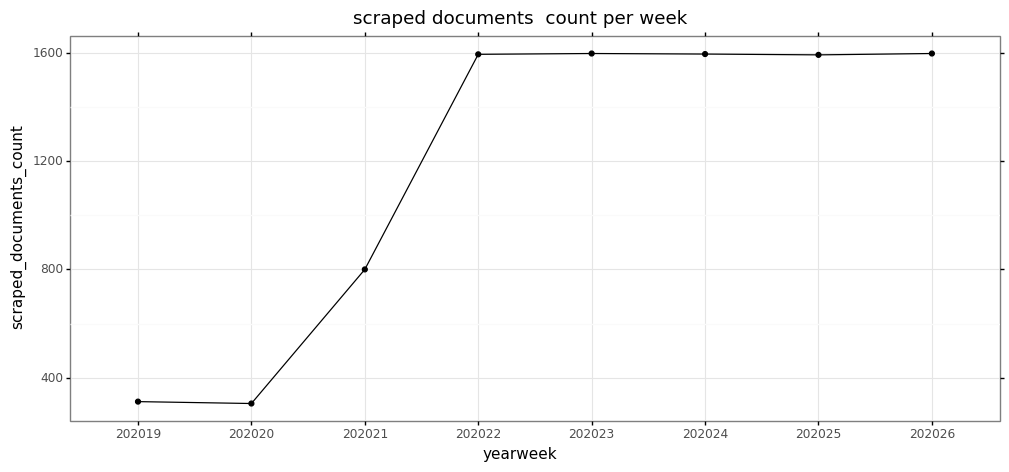

<ggplot: (-9223371882977802136)>


In [8]:
p = (ggplot(aes(x = 'yearweek', y = 'scraped_documents_count', group = 1), data = df2)
    + geom_line()
    + geom_point()
    + labs(title = 'scraped documents  count per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))
print(p)

## number of distinct ads

In [9]:
q3 = len(adcollection.distinct('properties.link'))
print(f"Number of distinct ads: {q3}")

Number of distinct ads: 4336


## number of ads with tags

In [10]:
q4 = adcollection_d.count_documents({'tags.1':{'$exists':True}, 'scraped timestamp': {'$lt': end, '$gte': start}})
print(f"Number of ads with atleast 1 tag: {q4}")

Number of ads with atleast 1 tag: 1962


In [11]:
q4_0 = list(adcollection.aggregate([    
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                                       {'$toString':{'$week':'$scraped timestamp'}}]
                            },
                'tags':1}
    },
    {'$match':{'tags.1':{'$exists':True}}},
    {'$group':{'_id':'$yearweek', 'documents_count':{'$sum':1}}}
    
    
]))

df4_0 = pd.json_normalize(q4_0)\
    .rename(columns = {'_id':'yearweek', 'documents_count':'ads_with_tags_count'})\
    .sort_values('yearweek')
df4_0.pivot_table(columns = 'yearweek')

yearweek             202019  202020  202021  202022  202023  202024  202025  \
ads_with_tags_count     121     109     344     689     746     744     700   

yearweek             202026  
ads_with_tags_count     705

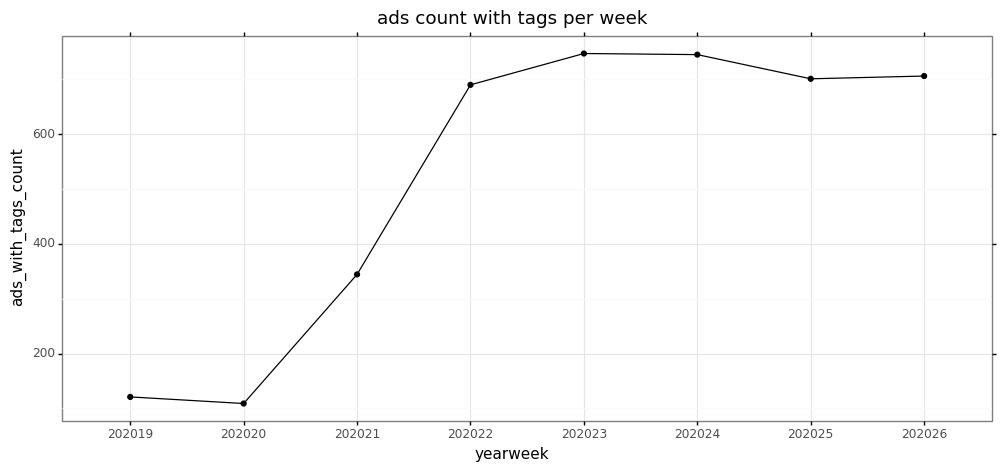

<ggplot: (-9223371882977758068)>


In [12]:
p = (ggplot(aes(x = 'yearweek', y = 'ads_with_tags_count', group = 1), data = df4_0)
    + geom_line()
    + geom_point()
    + labs(title = 'ads count with tags per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))
print(p)

## counts of tags

In [13]:
q4_2 = list(adcollection.aggregate([
    {'$match': {'scraped timestamp': {'$lt': end, '$gte': start}}},
        {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                                       {'$toString':{'$week':'$scraped timestamp'}}]
                            },
                'tags':1}
    },
	{'$unwind':'$tags'},
	{'$group':{'_id':{'yearweek':'$yearweek', 'tags':'$tags'}, 'tag_count':{'$sum':1}
		}
  
  }
	
]))
	
df4_2 = pd.json_normalize(q4_2)\
    .rename(columns = {'_id.tags':'tag', '_id.yearweek':'yearweek'})\
    .sort_values('tag_count', ascending = False)

df4_3 = df4_2.pivot_table(columns = 'yearweek', index = 'tag', values = 'tag_count')
df4_3['total'] = df4_3.sum(axis = 1)
df4_3 = df4_3.sort_values(by = 'total', ascending = False)

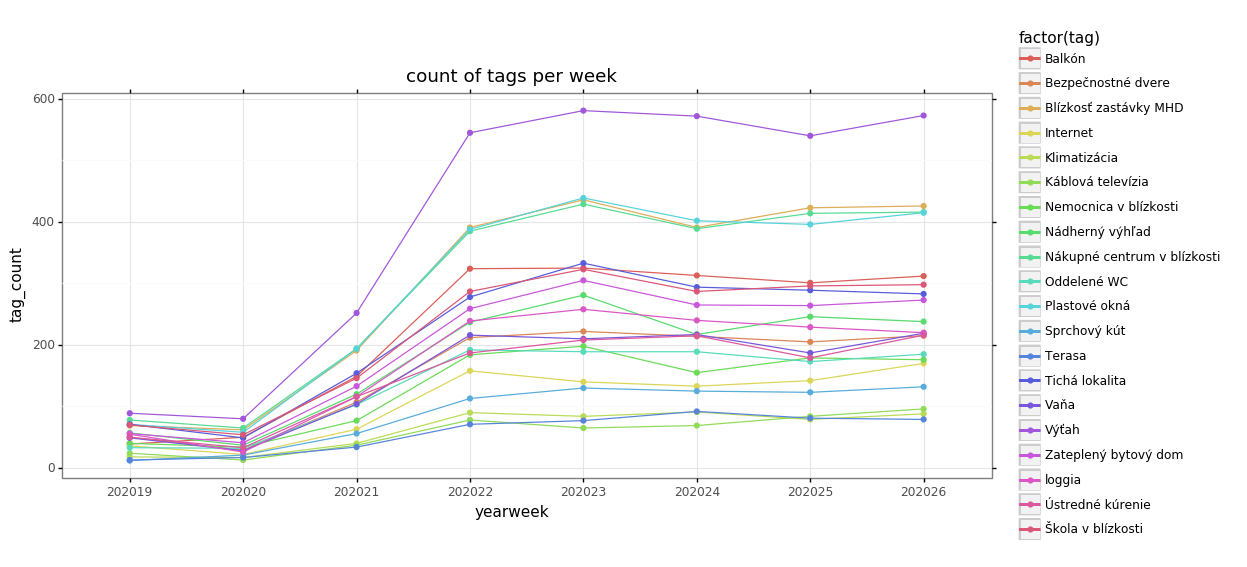

<ggplot: (-9223371882977536420)>


In [14]:
p = (ggplot(aes(x = 'yearweek', y = 'tag_count', color = 'factor(tag)', group = 'factor(tag)'), data = df4_2.loc[df4_2['tag'].isin(list(df4_3.index[:20])),:])
    + geom_line()
    + geom_point()
    + labs(title = 'count of tags per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))
print(p)

In [15]:
df4_3.head(20).style.format("{:.0f}")

In [16]:
q4_1 = list(adcollection_d.aggregate([
    {'$match': {'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$unwind':'$tags'},
	{'$group':{'_id':'$tags', 'tag_count':{'$sum':1}
		}
  
  }
	
]))
	
df4_1 = pd.json_normalize(q4_1)\
    .rename(columns = {'_id':'tag'})\
    .sort_values('tag_count', ascending = False)
df4_1.head(20)

tag  tag_count
84                        Výťah       1472
27        Blízkosť zastávky MHD       1238
37  Nákupné centrum v blízkosti       1225
63                Plastové okná       1202
44            Škola v blízkosti       1063
8                Tichá lokalita       1006
14         Zateplený bytový dom        886
28              Nádherný výhľad        820
10                       loggia        757
12                       Balkón        742
15        Nemocnica v blízkosti        642
47             Ústredné kúrenie        632
16                         Vaňa        622
53           Bezpečnostné dvere        609
11                  Oddelené WC        563
71                     Internet        482
41                 Sprchový kút        377
82            Káblová televízia        281
1                  Klimatizácia        226
85          Lokálne vykurovanie        200

## number of ads with map coordinates

In [17]:
q5 = adcollection_d.count_documents({'mapcoord.lon':{'$exists':True}, 'scraped timestamp': {'$lt': end, '$gte': start}})
print(f"Number of ads with map coordinates: {q5}")

Number of ads with map coordinates: 3837


In [18]:
q5_1 = list(adcollection.aggregate([
    {'$match': {'scraped timestamp': {'$lt': end, '$gte': start}}},
        {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                                       {'$toString':{'$week':'$scraped timestamp'}}]
                            },
                'mapcoord':1}
    },
	{'$group':{'_id':'$yearweek', 'with_mapcoord_count':{'$sum':1}
		}
  
  }
	
]))
	
df5_1 = pd.json_normalize(q5_1)\
    .rename(columns = {'_id':'yearweek'})
df5_2 = df5_1.pivot_table(columns = 'yearweek')
df5_2['total'] = df5_2.sum(axis = 1)
df5_2

yearweek             202019  202020  202021  202022  202023  202024  202025  \
with_mapcoord_count     312     305     800    1594    1597    1595    1592   

yearweek             202026  total  
with_mapcoord_count    1597   9392

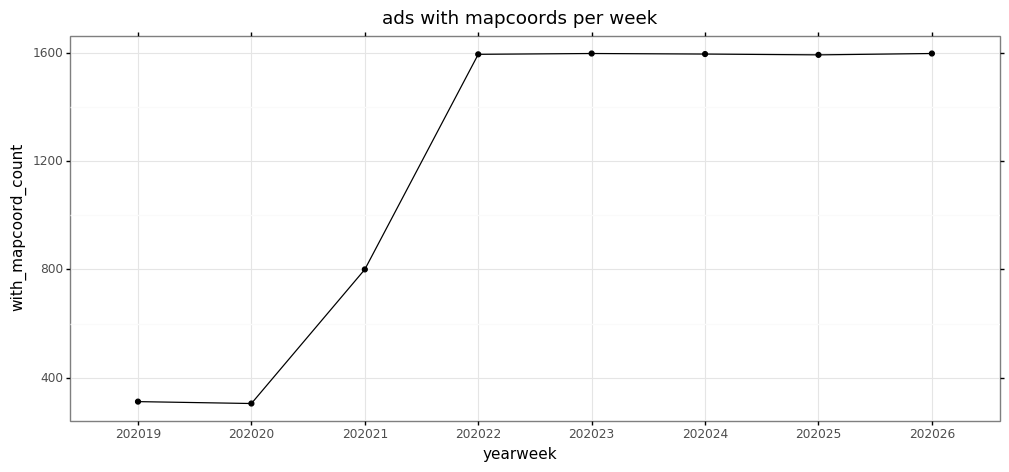

<ggplot: (-9223371882977127272)>


In [19]:
p = (ggplot(aes(x = 'yearweek', y = 'with_mapcoord_count', group = 1), data = df5_1)
    + geom_line()
    + geom_point()
    + labs(title = 'ads with mapcoords per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))
print(p)

## counts of keys in properties

In [20]:
q5_1 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$project':{
		'properties':{'$objectToArray':'$properties'}
		}
  
  },
	{'$unwind':'$properties'},
	{'$group':{'_id':'$properties.k',
			'ads_count':{'$sum':1}
		}
  
  }
	
]))
	
df5_1 = pd.json_normalize(q5_1)\
    .rename(columns = {'_id':'property'})\
    .sort_values('ads_count', ascending = False)
df5_1

property  ads_count
19       Balkón / loggia       4336
3                Pivnica       4336
4           Cena dohodou       4336
18             Kategória       4336
8                   link       4336
10          Aktualizácia       4336
12              Lokalita       4336
9        Úžitková plocha       4310
0                   Cena       4207
1        Provízia v cene       4207
15         Cena za meter       4171
5                  Ulica       3839
13                 Výťah       3554
21  Identifikačné číslo:       3522
14             Poschodie       3489
2         Pocet poschodi       3489
17                  Stav       3090
11              Materiál       2336
16   Stav nehnuteľnosti:       1305
6       Zastavaná plocha        100
20            Pozemok m2         73
7                 empty1         22

## counts of distinct values in properties

In [21]:
q5_2 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$project':{
		'properties':{'$objectToArray':'$properties'}
		}
  
  },
	{'$unwind':'$properties'},
	{'$group':{'_id':'$properties.k',
			'unique_values':{'$addToSet': "$properties.v"}
		}
    },
     {'$project':{'_id':1,
                 'unique_values_count':{'$size':'$unique_values'}}
     
     }
  

	
]))
	
df5_2 = pd.json_normalize(q5_2)\
    .rename(columns = {'_id':'property'})\
    .sort_values('unique_values_count', ascending = False)
df5_2

property  unique_values_count
8                   link                 4336
21  Identifikačné číslo:                 3194
10          Aktualizácia                 1793
15         Cena za meter                 1645
0                   Cena                 1031
5                  Ulica                  758
9        Úžitková plocha                  215
12              Lokalita                   66
6       Zastavaná plocha                   62
20            Pozemok m2                   52
2         Pocet poschodi                   32
14             Poschodie                   27
7                 empty1                   11
18             Kategória                   10
11              Materiál                    5
17                  Stav                    4
1        Provízia v cene                    3
3                Pivnica                    2
19       Balkón / loggia                    2
4           Cena dohodou                    2
13                 Výťah                    2
16   Stav nehnuteľnosti:                    1

## number of ads per flat category

In [22]:
q6 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                               {'$toString':{'$week':'$scraped timestamp'}}]
                    },
        'properties':1}
    },
    {'$group':{'_id':{'yearweek':'$yearweek', 'flat_category':'$properties.Kategória'}, 'ads_count':{'$sum':1}}}]))

df6 = pd.json_normalize(q6)\
    .rename(columns = {'_id.yearweek':'yearweek', '_id.flat_category':'flat_category'})\
    .sort_values('ads_count', ascending = False)
df7 = df6.pivot_table(columns = 'yearweek', index = 'flat_category', values = 'ads_count')
df7['total'] = df7.sum(axis = 1)

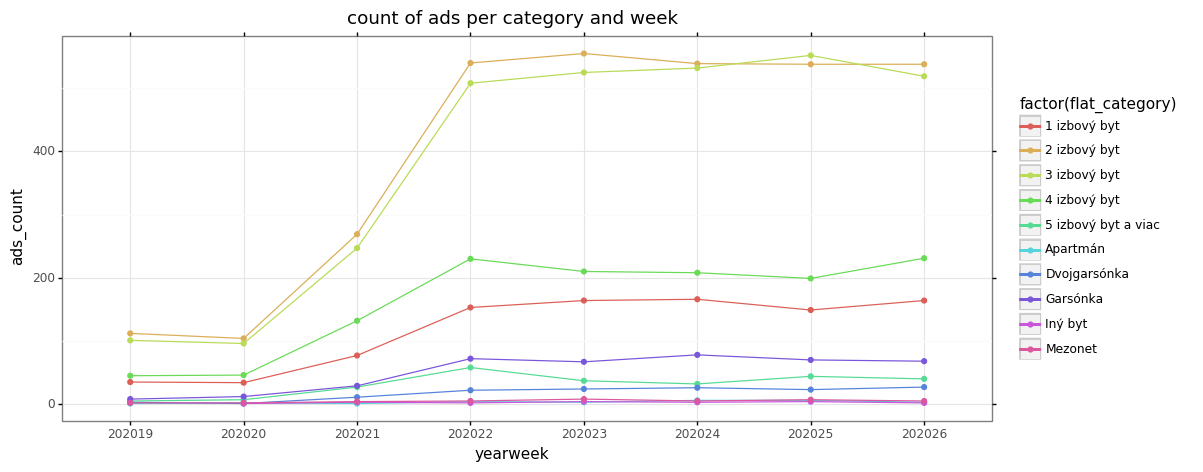

<ggplot: (-9223371882976976484)>


In [23]:
p = (ggplot(aes(x = 'yearweek', y = 'ads_count', color = 'factor(flat_category)', group = 'factor(flat_category)'), 
            data = df6)
    + geom_line()
    + geom_point()
    + labs(title = 'count of ads per category and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))
print(p)

In [24]:
df7.style.format("{:.0f}")

In [25]:
q6_1 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$group':{'_id':'$properties.Kategória', 'ads_count':{'$sum':1}}}]))

df6_1 = pd.json_normalize(q6_1)\
    .rename(columns = {'_id':'flat_category'})\
    .sort_values('ads_count', ascending = False)
df6_1

flat_category  ads_count
9         2 izbový byt       1503
1         3 izbový byt       1413
3         4 izbový byt        569
6         1 izbový byt        446
2             Garsónka        208
0  5 izbový byt a viac        101
4         Dvojgarsónka         66
5              Mezonet         15
7             Apartmán         10
8              Iný byt          5

## number of ads per state and category

In [26]:
q8 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                           {'$toString':{'$week':'$scraped timestamp'}}]
                },
    'properties':1}
    },
    {'$group':{'_id':{'yearweek':'$yearweek', 'kategoria':'$properties.Kategória', 'stav':'$properties.Stav'}, 'ads_count':{'$sum':1}}}]))

df8 = pd.json_normalize(q8)\
    .rename(columns = {'_id.kategoria':'category', '_id.stav':'state', '_id.yearweek':'yearweek'})\
    .sort_values(['state', 'ads_count'], ascending = False)
df8 = df8[['state', 'category', 'yearweek','ads_count']]
df9 = df8.pivot_table(index=['category','state'], columns='yearweek', values='ads_count')
df9['total'] = df9.sum(axis = 1)

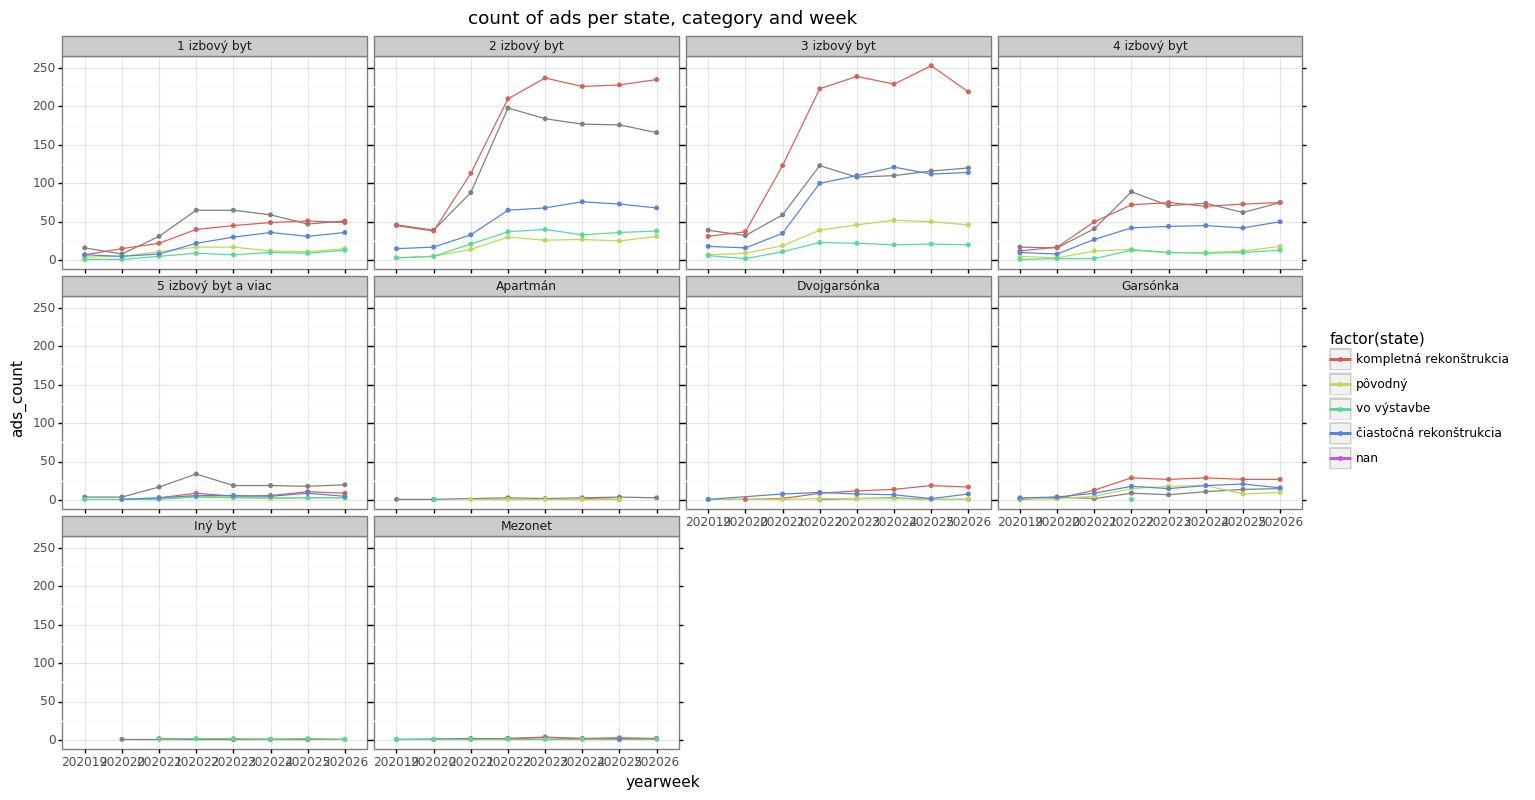

<ggplot: (-9223371882977521832)>


In [27]:
p = (ggplot(aes(x = 'yearweek', y = 'ads_count', color = 'factor(state)', group = 'factor(state)'), 
            data = df8)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'count of ads per state, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [28]:
df9.style.format("{:.0f}", na_rep = '-')

In [29]:
q8 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$group':{'_id':{'kategoria':'$properties.Kategória', 'stav':'$properties.Stav'}, 'ads_count':{'$sum':1}}}]))

df8 = pd.json_normalize(q8)\
    .rename(columns = {'_id.kategoria':'category', '_id.stav':'state'})\
    .sort_values(['state', 'ads_count'], ascending = False)
df8 = df8[['state', 'category', 'ads_count']]
df8 = df8.pivot(index='state', columns='category', values='ads_count')
df8['state_count'] = df8.sum(axis = 1)
df8 = df8.sort_values('state_count', ascending = False)
df8.style.format("{:.0f}", na_rep = '-')

## number of ads per location and category

### counts

In [30]:
q10 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$group':{'_id':{'kategoria':'$properties.Kategória', 'lokalita':'$properties.Lokalita'}, 'ads_count':{'$sum':1}}}]))

df10 = pd.json_normalize(q10)\
    .rename(columns = {'_id.kategoria':'category', '_id.lokalita':'location'})
df10 = df10.pivot(index='location', columns='category', values='ads_count')
df10['location_count'] = df10.sum(axis = 1)
df10 = df10.sort_values('location_count', ascending = False)
df10.head(30).style.format("{:.0f}", na_rep = '-')

### percent

In [31]:
df11 = df10.iloc[:,[i for i in range(0, 10)]].apply(lambda x: x/df10['location_count'])
df11.head(30).style.format("{:.2%}", na_rep = '-')

### mean percent of category in top few locations

In [32]:
df11.loc[locs,:].mean().to_frame().style.format("{:.2%}")


## counts per yearweek

In [33]:
q8 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                           {'$toString':{'$week':'$scraped timestamp'}}]
                },
    'properties':1}
    },
    {'$group':{'_id':{'yearweek':'$yearweek', 'kategoria':'$properties.Kategória', 'location':'$properties.Lokalita'}, 'ads_count':{'$sum':1}}}]))

df8 = pd.json_normalize(q8)\
    .rename(columns = {'_id.kategoria':'category', '_id.location':'location', '_id.yearweek':'yearweek'})
df8 = df8[['location', 'category', 'yearweek','ads_count']]
df8 = df8.loc[df8['location'].isin(locs),:]
df9 = df8.pivot_table(index=['category','location'], columns='yearweek', values='ads_count')
df9['total'] = df9.sum(axis = 1)

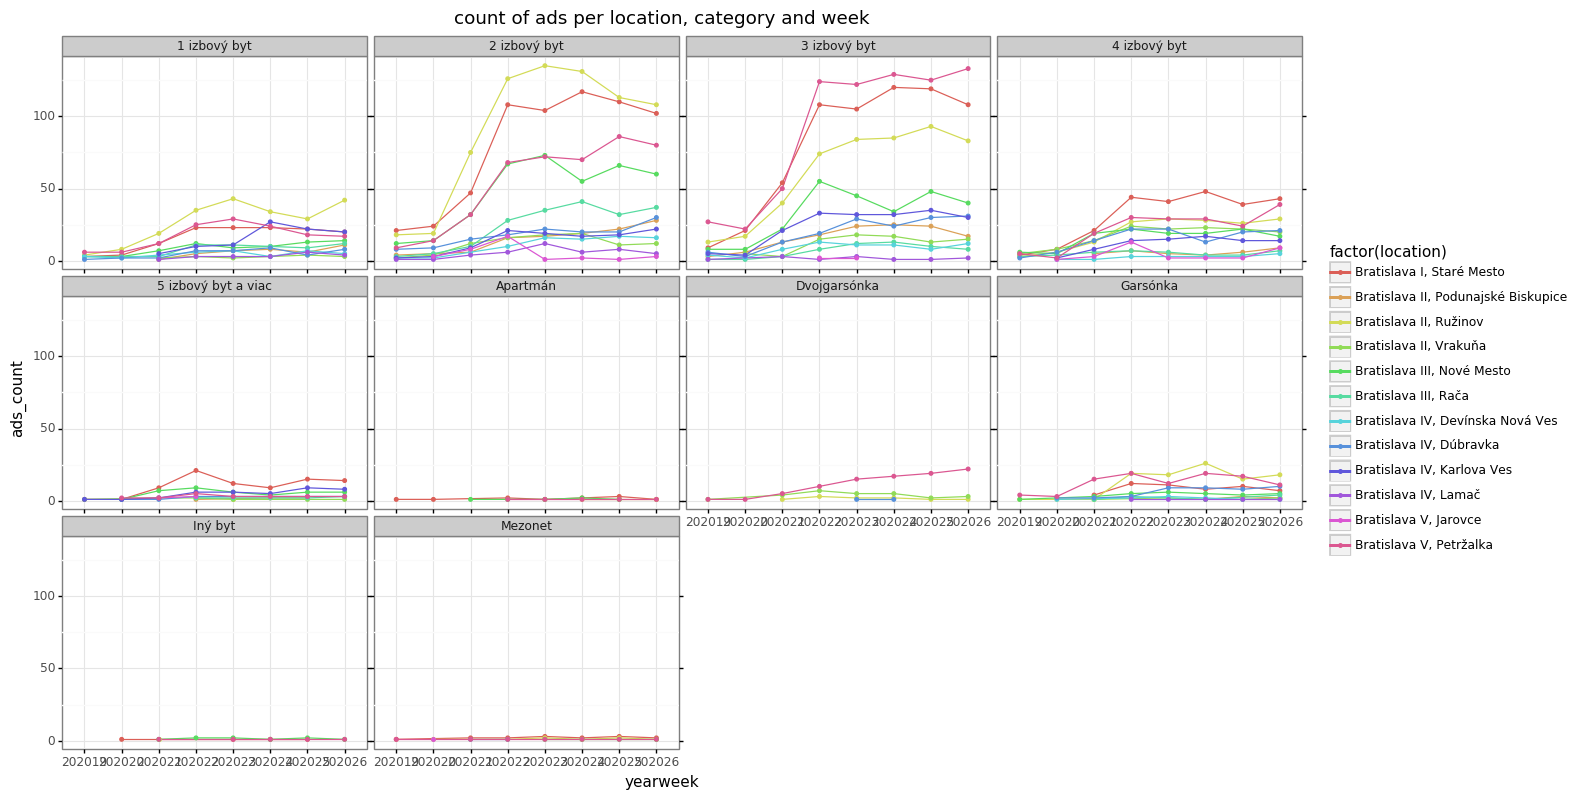

<ggplot: (-9223371882974315312)>


In [34]:
p = (ggplot(aes(x = 'yearweek', y = 'ads_count', color = 'factor(location)', group = 'factor(location)'), 
            data = df8)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'count of ads per location, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [35]:
df9.style.format("{:.0f}", na_rep = '-')

# AVG PRICE

In [36]:
q12 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':'global',
			'price_avg':{'$avg':'$properties.Cena'}
		}
  
  }
	
]))[0]['price_avg']

print(f"Average price of whole set: {q12}")

Average price of whole set: 194841.48585690517


In [37]:
q12 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                       {'$toString':{'$week':'$scraped timestamp'}}]
            },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek'},
			'price_avg':{'$avg':'$properties.Cena'}
		}
  
  }
	
]))
	
df12 = pd.json_normalize(q12)\
    .rename(columns = {'_id.yearweek':'yearweek'})
df13 = df12.pivot_table(columns = 'yearweek')
df13.style.format("{:,.0f}")


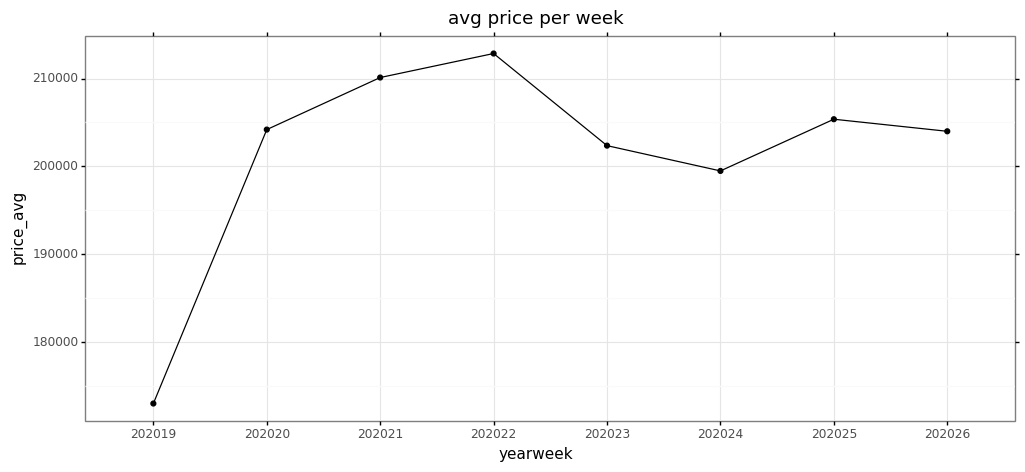

<ggplot: (-9223371882975221396)>


In [38]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', group = 1), 
            data = df12)
    + geom_line()
    + geom_point()
    + labs(title = 'avg price per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

## avg price per category

In [39]:
q13 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                   {'$toString':{'$week':'$scraped timestamp'}}]
        },
    'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'}}  
  }
	
]))
	
df13 = pd.json_normalize(q13)\
    .rename(columns = {'_id.category':'category', '_id.yearweek':'yearweek'})\
    .sort_values('price_avg', ascending = False)
df13 = df13[['category', 'yearweek', 'price_avg']]
df14 = df13.pivot_table(columns = 'yearweek', index = 'category', values = 'price_avg')

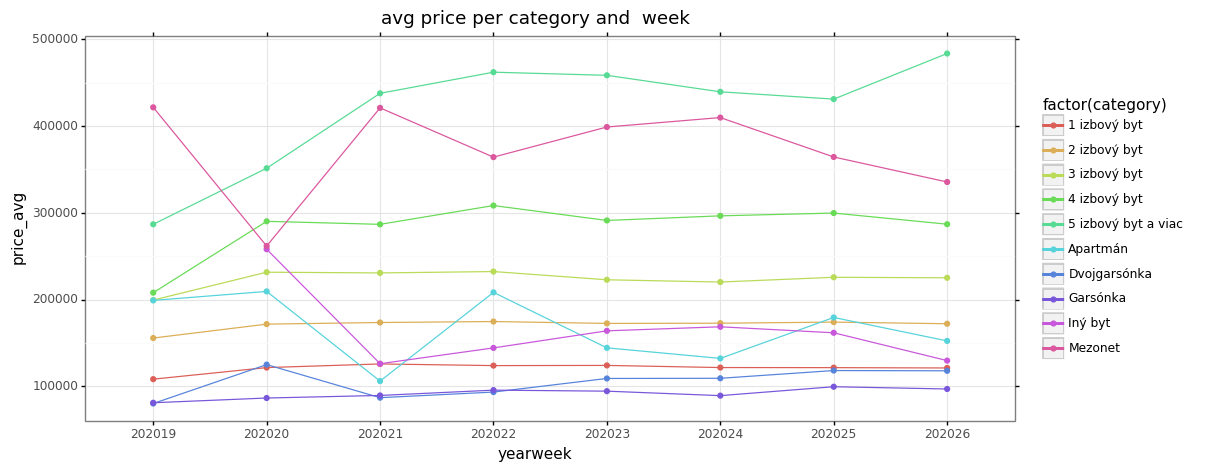

<ggplot: (-9223371882976905768)>


In [40]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(category)', group = 'factor(category)'), 
            data = df13)
    + geom_line()
    + geom_point()
    + labs(title = 'avg price per category and  week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [41]:
df14.style.format("{:,.0f}")

In [42]:
q13 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'},
            'ads_count':{'$sum':1}}  
  }
	
]))
	
df13 = pd.json_normalize(q13)\
    .rename(columns = {'_id.category':'category'})\
    .sort_values('price_avg', ascending = False)
df13 = df13[['category', 'price_avg', 'ads_count']]
df13.style.format({'price_avg':"{:,.0f}"})

## avg price per location

In [43]:
q14 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
               {'$toString':{'$week':'$scraped timestamp'}}]
    },
    'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek','location':'$properties.Lokalita'},
			'price_avg':{'$avg':'$properties.Cena'}}  
  }
	
]))
	
df14 = pd.json_normalize(q14)\
    .rename(columns = {'_id.location':'location', '_id.yearweek':'yearweek'})
df14 = df14.loc[df14['location'].isin(locs), ['location', 'yearweek', 'price_avg']]
df15 = df14.pivot_table(columns = 'yearweek', index = 'location', values = 'price_avg')

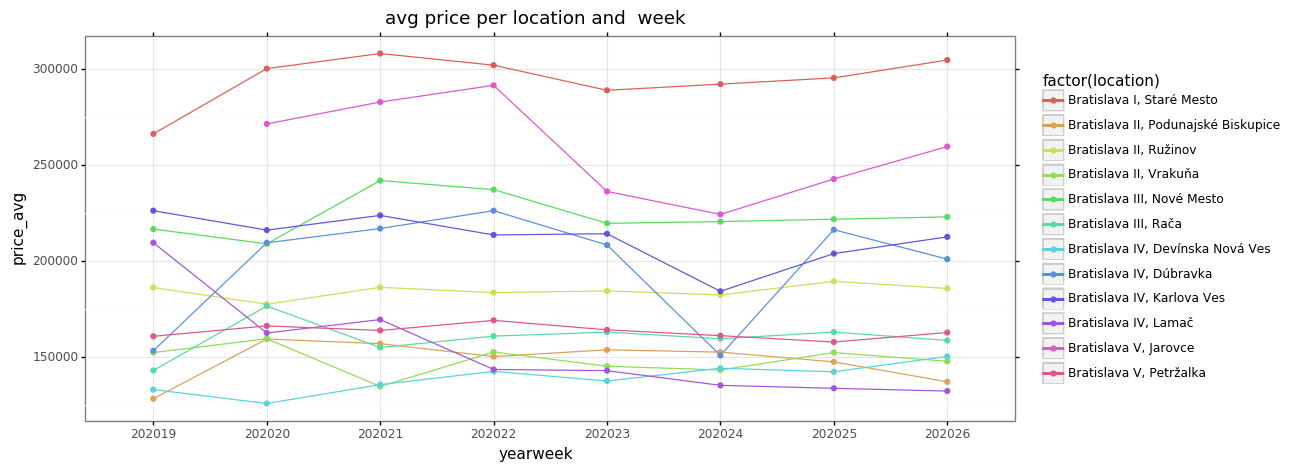

<ggplot: (-9223371882976902664)>


In [44]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df14)
    + geom_line()
    + geom_point()
    + labs(title = 'avg price per location and  week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [45]:
df15.style.format("{:,.0f}")

In [46]:
q14 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}  
  }
	
]))
	
df14 = pd.json_normalize(q14)\
    .rename(columns = {'_id.location':'location'})\
    .sort_values('price_avg', ascending = False)
df14 = df14[['location', 'price_avg', 'ads_count']]
df15 = df14.loc[df14['location'].isin(locs),:]
df15.style.format({'price_avg':"{:,.0f}"})

## avg price per location and category

In [47]:
q16 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
           {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'}}  
  }
	
]))
	
df16 = pd.json_normalize(q16)\
    .rename(columns = {'_id.location':'location', '_id.category':'category', '_id.yearweek':'yearweek'})\
    .sort_values('price_avg', ascending = False)
df16 = df16.loc[df16['location'].isin(locs), ['location', 'yearweek', 'category', 'price_avg']]
df17 = df16.pivot_table(columns = 'yearweek', index = ['category', 'location'], values = 'price_avg')

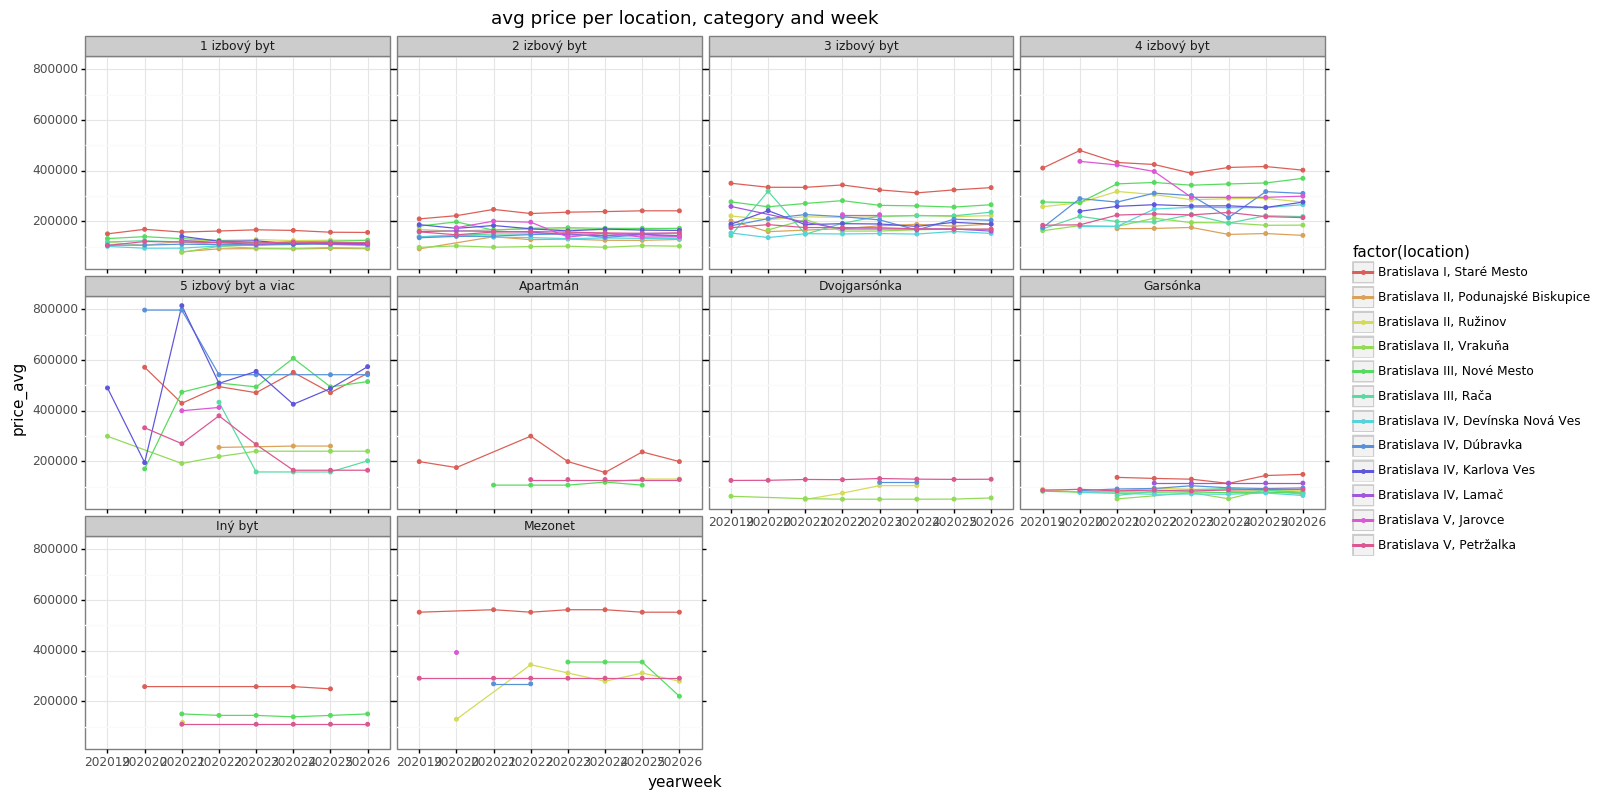

<ggplot: (-9223371882974119376)>


In [48]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg price per location, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [49]:
df17.style.format("{:,.0f}", na_rep = '-')

In [50]:
q17 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}  
  }
	
]))
	
df17 = pd.json_normalize(q17)\
    .rename(columns = {'_id.location':'location', '_id.category':'category'})\
    .sort_values('price_avg', ascending = False)
df17 = df17[['location', 'category', 'price_avg', 'ads_count']]
df17.loc[df17['location'].isin(locs),:]
df18 = df17.loc[df17['location'].isin(locs),:].pivot(index='location', columns='category', values='price_avg')
df18.style.format("{:,.0f}", na_rep = '-')

### 2 room apartment

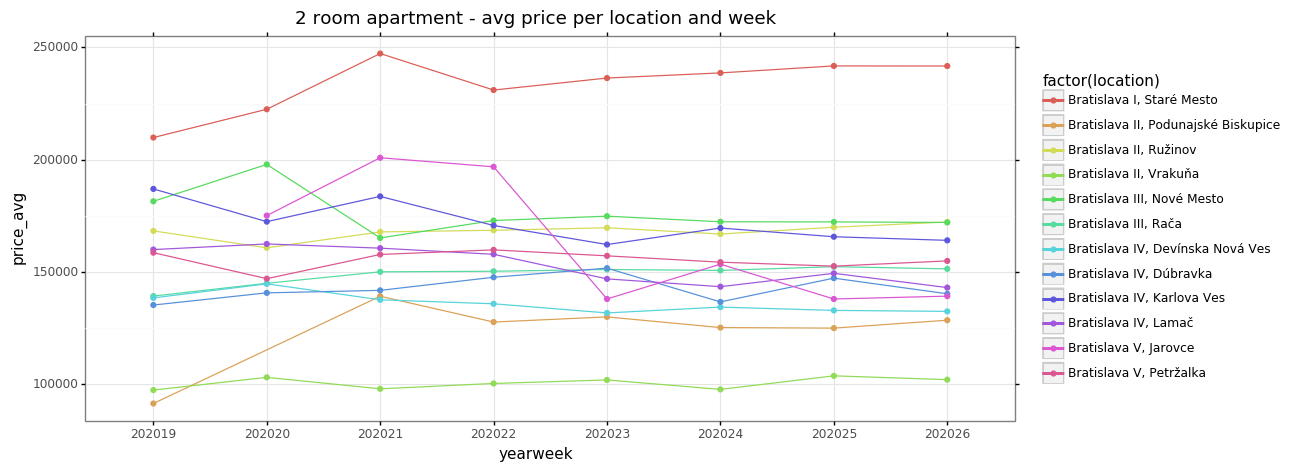

<ggplot: (-9223371882977345676)>


In [51]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16.loc[df16['category'] == '2 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '2 room apartment - avg price per location and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

### 3 room apartment

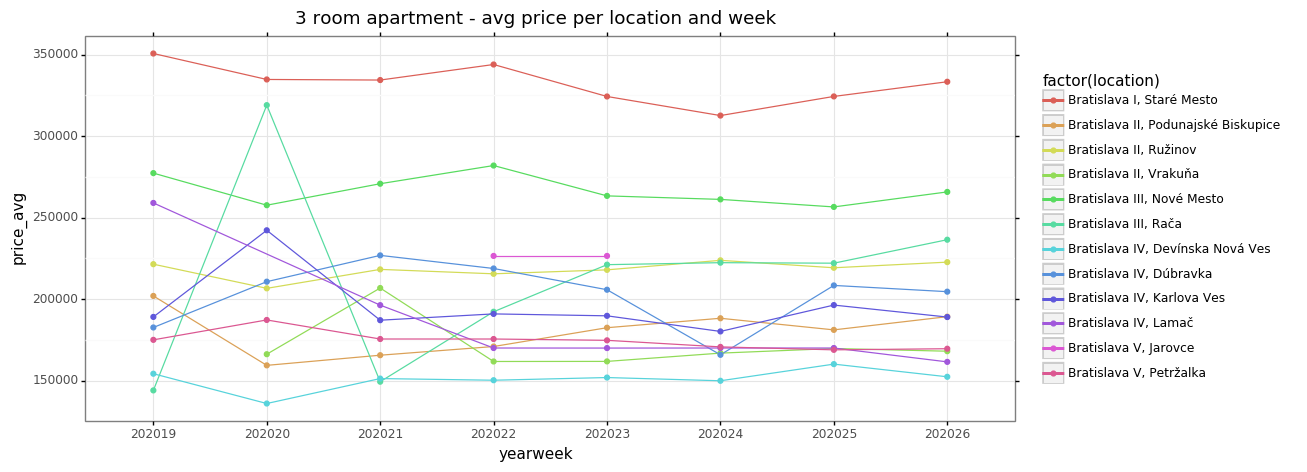

<ggplot: (-9223371882977369792)>


In [52]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16.loc[df16['category'] == '3 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '3 room apartment - avg price per location and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

## avg price per state

In [53]:
q18 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'state':'$properties.Stav'},
			'price_avg':{'$avg':'$properties.Cena'}}
  }
	
]))
	
df18 = pd.json_normalize(q18)\
    .rename(columns = {'_id.state':'state', '_id.yearweek':'yearweek'})\
    .sort_values('price_avg', ascending = False)
df18 = df18[['state', 'yearweek', 'price_avg']]
df19 = df18.pivot_table(columns = 'yearweek', index = 'state', values = 'price_avg')

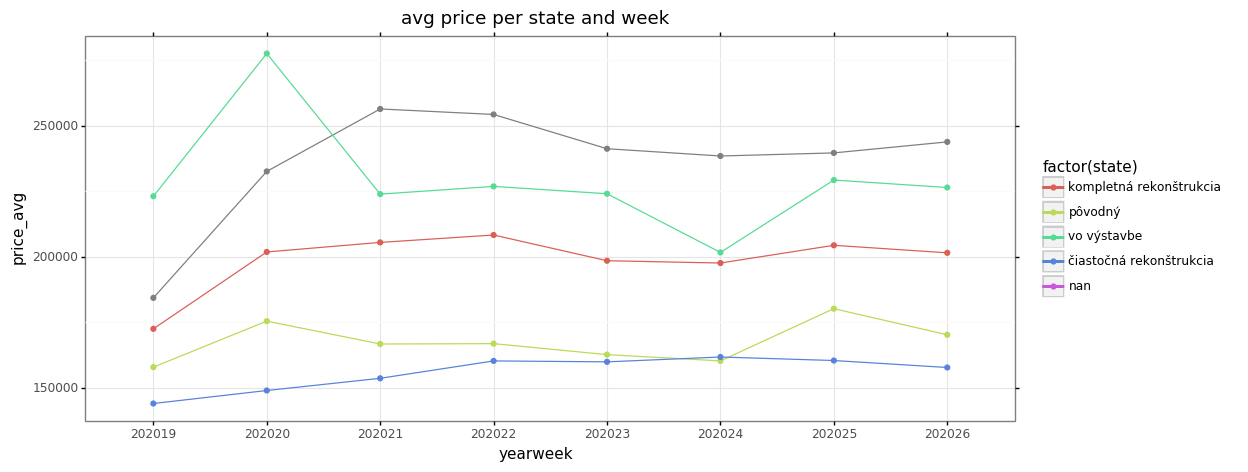

<ggplot: (-9223371882974632936)>


In [54]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df18)
    + geom_line()
    + geom_point()
    + labs(title = 'avg price per state and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [55]:
df19.style.format("{:,.0f}")

In [56]:
q18 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'state':'$properties.Stav'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df18 = pd.json_normalize(q18)\
    .rename(columns = {'_id.state':'state'})\
    .sort_values('price_avg', ascending = False)
df18 = df18[['state', 'price_avg', 'ads_count']]
df18.style.format({'price_avg':"{:,.0f}"})

## avg price per state and category

In [57]:
q19 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'}}
		
  
  }
	
]))
	
df19 = pd.json_normalize(q19)\
    .rename(columns = {'_id.state':'state', '_id.category':'category', '_id.yearweek':'yearweek'})
df19 = df19[['state', 'category', 'yearweek', 'price_avg']]
df20 = df19.pivot_table(index = ['state', 'category'], columns = 'yearweek', values = 'price_avg')

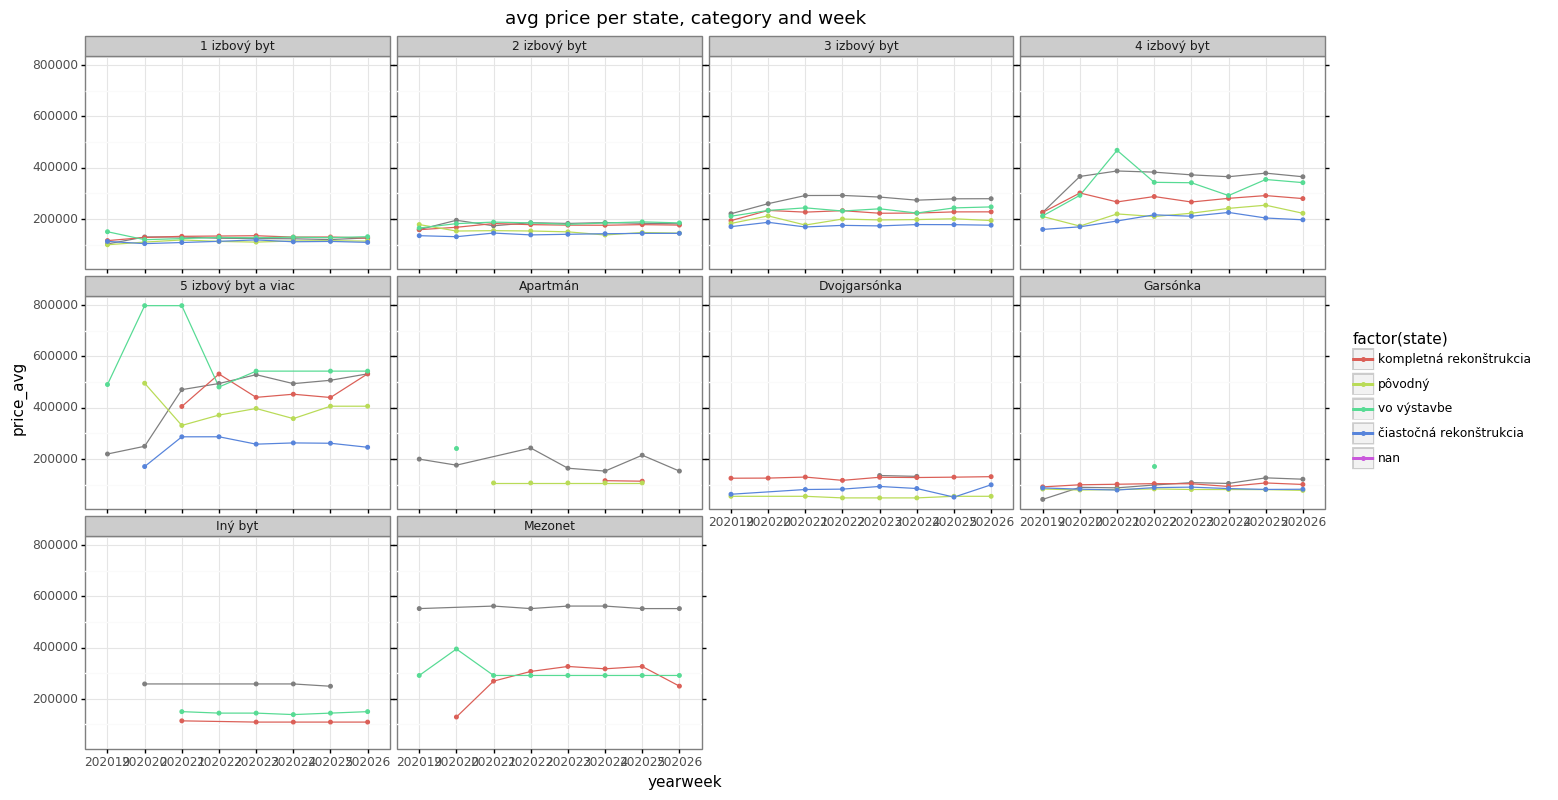

<ggplot: (-9223371882974362664)>


In [58]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df19)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg price per state, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [59]:
df20.style.format("{:,.0f}", na_rep = '-')

In [60]:
q20 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df20 = pd.json_normalize(q20)\
    .rename(columns = {'_id.state':'state', '_id.category':'category'})\
    .sort_values(['state', 'price_avg'], ascending = False)
df20 = df20[['state', 'category', 'price_avg', 'ads_count']]
df20 = df20.pivot(index = 'state', columns = 'category', values = 'price_avg')
df20.style.format("{:,.0f}", na_rep = '-')

### 2 room apartment

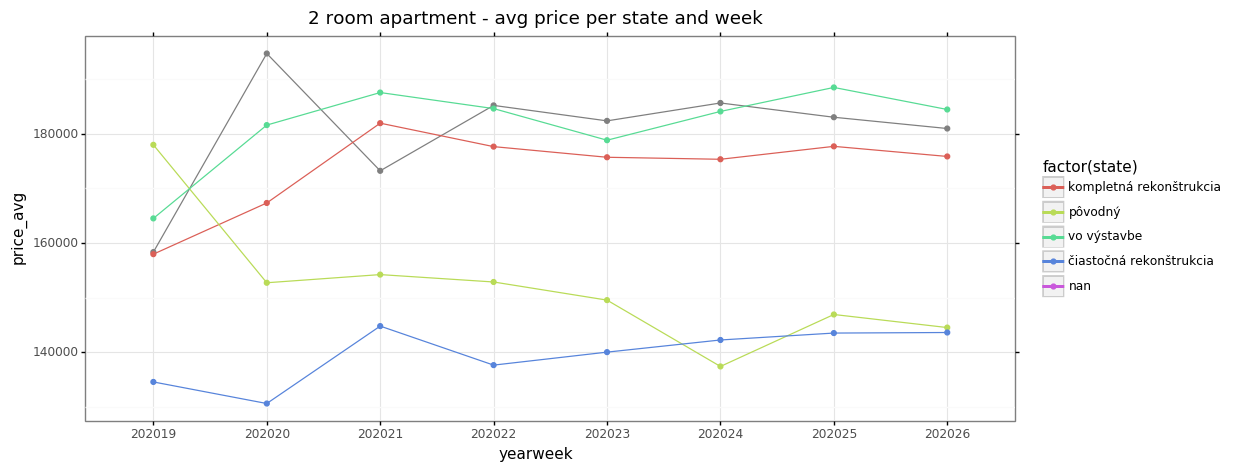

<ggplot: (-9223371882974936388)>


In [61]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df19.loc[df19['category'] == '2 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '2 room apartment - avg price per state and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

### 3 room apartment

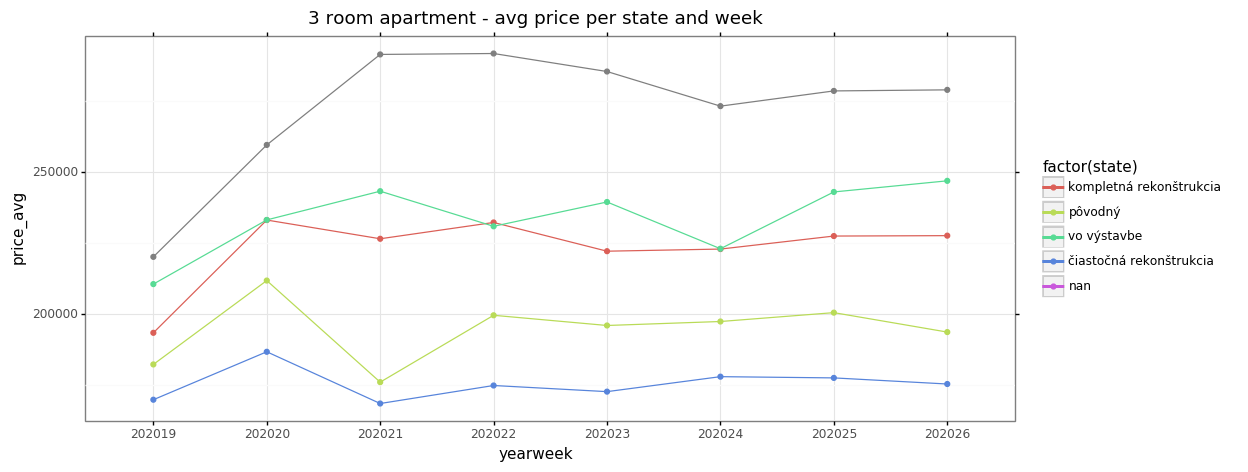

<ggplot: (-9223371882976966520)>


In [62]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df19.loc[df19['category'] == '3 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '3 room apartment - avg price per state and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

## avg price per state and location

In [63]:
q20 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
        {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita', 'state':'$properties.Stav'},
			'price_avg':{'$avg':'$properties.Cena'}}
		
  
  }
	
]))
	
df20 = pd.json_normalize(q20)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.yearweek':'yearweek'})
df20 = df20[['location', 'yearweek', 'state', 'price_avg']]
df21 = df20.loc[df20['location'].isin(locs),:].pivot_table(index = ['state', 'location'], columns = 'yearweek', values = 'price_avg')

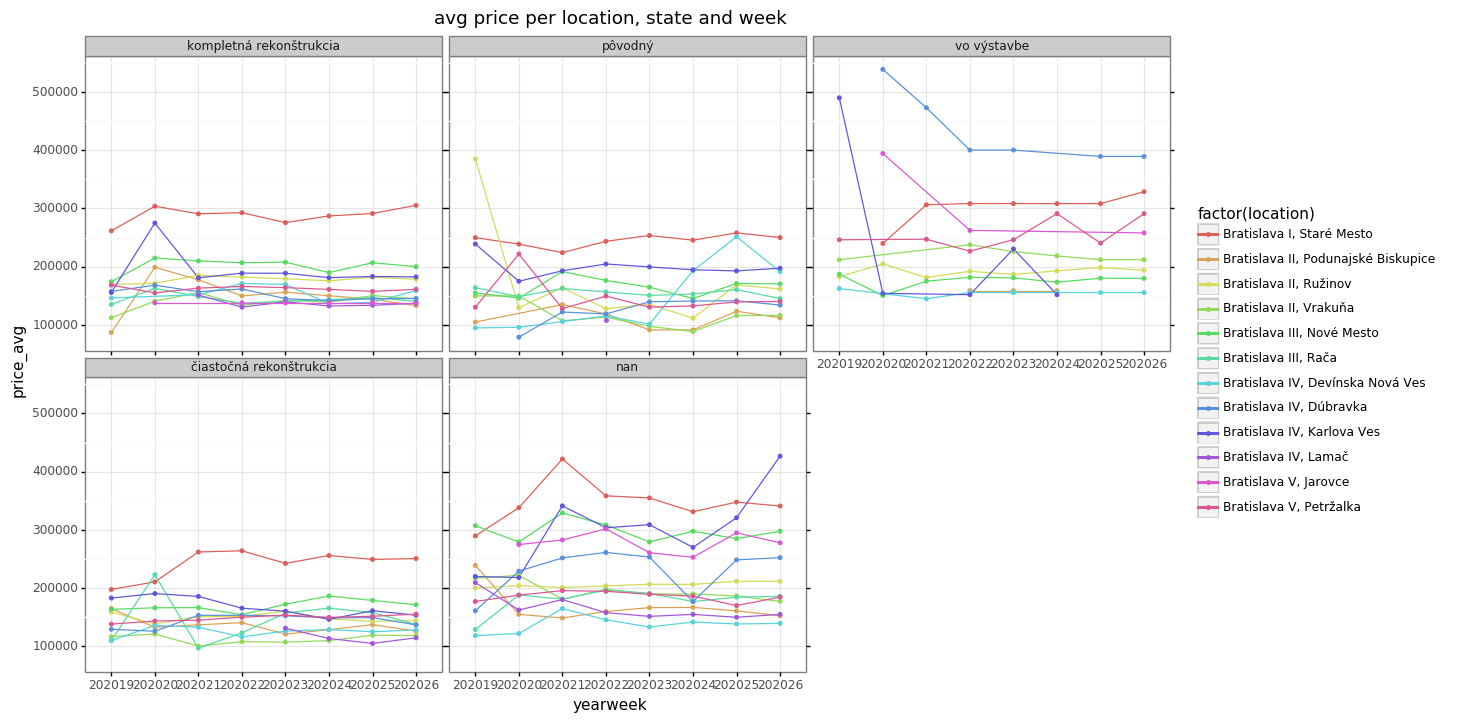

<ggplot: (-9223371882975579652)>


In [64]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df20.loc[df20['location'].isin(locs),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

In [65]:
df21.style.format("{:,.0f}", na_rep = '-')

In [66]:
q20 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'state':'$properties.Stav'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df20 = pd.json_normalize(q20)\
    .rename(columns = {'_id.location':'location', '_id.state':'state'})\
    .sort_values('price_avg', ascending = False)
df20 = df20[['location', 'state', 'price_avg', 'ads_count']]
df20 = df20.loc[df20['location'].isin(locs),:].pivot(index = 'location', columns = 'state', values = 'price_avg')
df20.style.format("{:,.0f}", na_rep = '-')

## avg price per state, location and category

In [67]:
q21 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'}}
		
  
  }
	
]))
	
df21 = pd.json_normalize(q21)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.category':'category', '_id.yearweek':'yearweek'})
df22 = df21.loc[df21['location'].isin(locs),:].pivot_table(index = ['category', 'state', 'location'], columns = 'yearweek', values = 'price_avg')
df22.style.format("{:,.0f}", na_rep = '-')

In [68]:
q22 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df22 = pd.json_normalize(q22)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.category':'category'})\
    .sort_values('price_avg', ascending = False)
df22 = df22.loc[df22['location'].isin(locs),:].pivot_table(index = ['location', 'category'], columns = 'state', values = ['price_avg', 'ads_count'])
df22.columns = df22.columns.swaplevel(0, 1)
df22.sort_index(axis=1, level=0, inplace=True)
df22.style.format("{:,.0f}", na_rep = '-')

### 2 room apartment

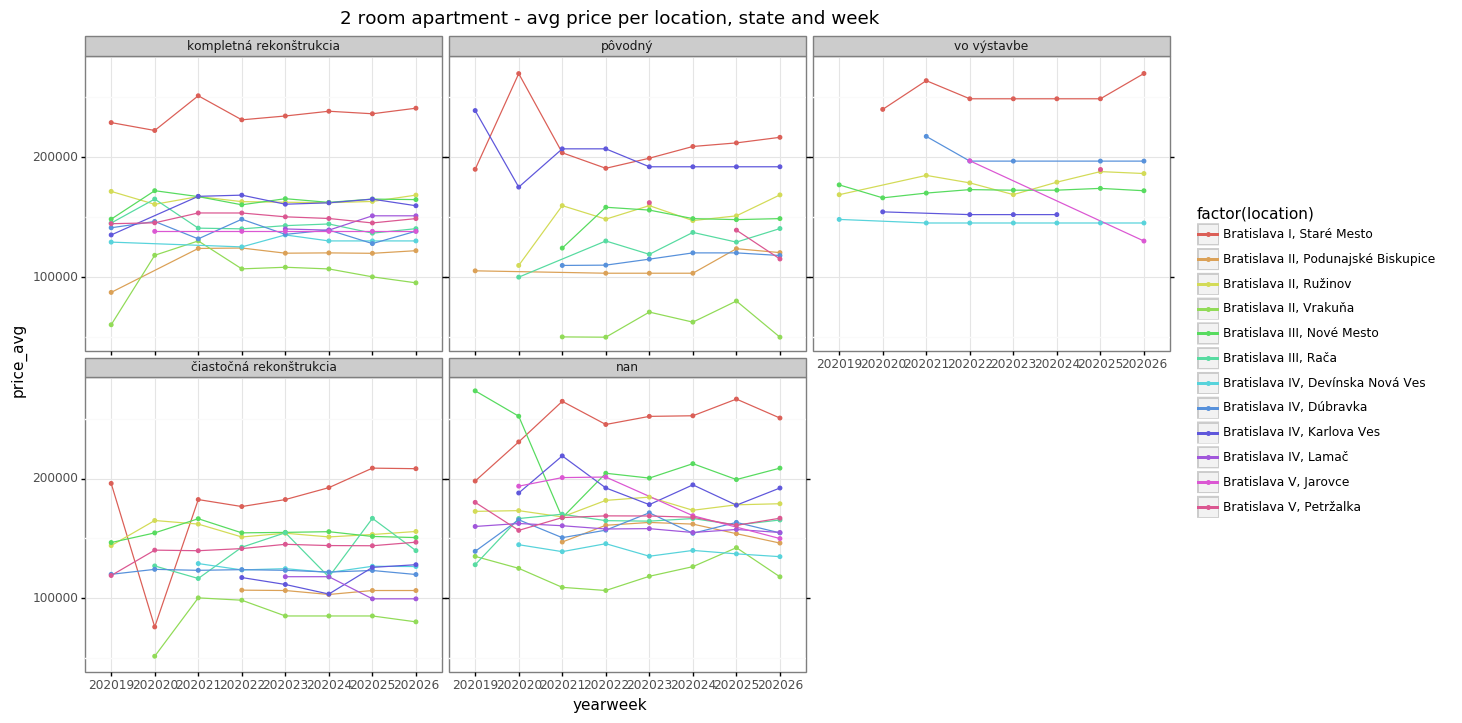

<ggplot: (-9223371882975455972)>


In [69]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df21.loc[(df21['category']== '2 izbový byt') & (df21['location'].isin(locs)),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '2 room apartment - avg price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

### 3 room apartment

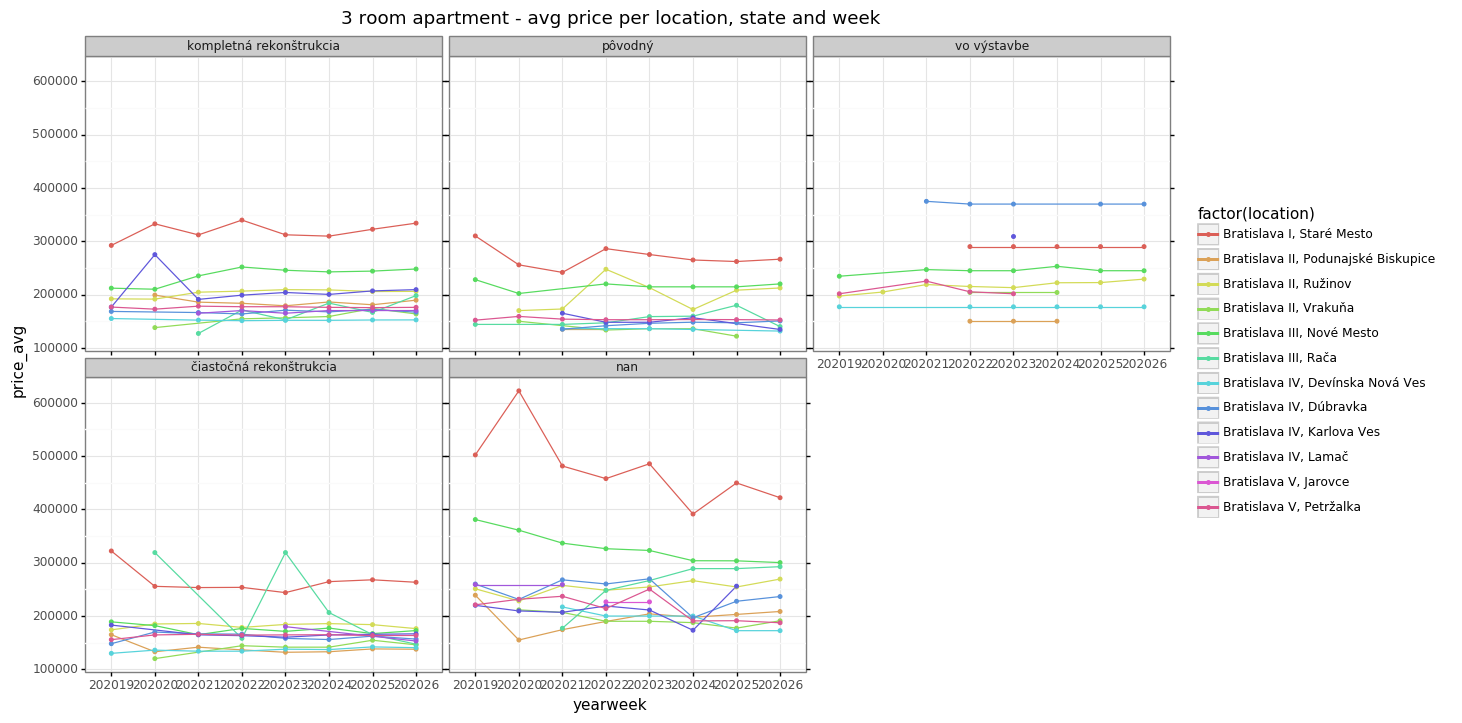

<ggplot: (-9223371882975035284)>


In [70]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df21.loc[(df21['category']== '3 izbový byt') & (df21['location'].isin(locs)),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '3 room apartment - avg price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

# AVG M2 PRICE

In [71]:
q12 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':'global',
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}
		}
  
  }
	
]))[0]['price_m2_avg']
	
print(f"Average price of whole set: {q12}")


Average price of whole set: 2914.427235674898


In [72]:
q12 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':'$yearweek',
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}
		}
  
  }
	
]))
	
df12 = pd.json_normalize(q12)\
    .rename(columns = {'_id':'yearweek'})
df13 = df12.pivot_table(columns = 'yearweek')
df13.style.format("{:.0f}")

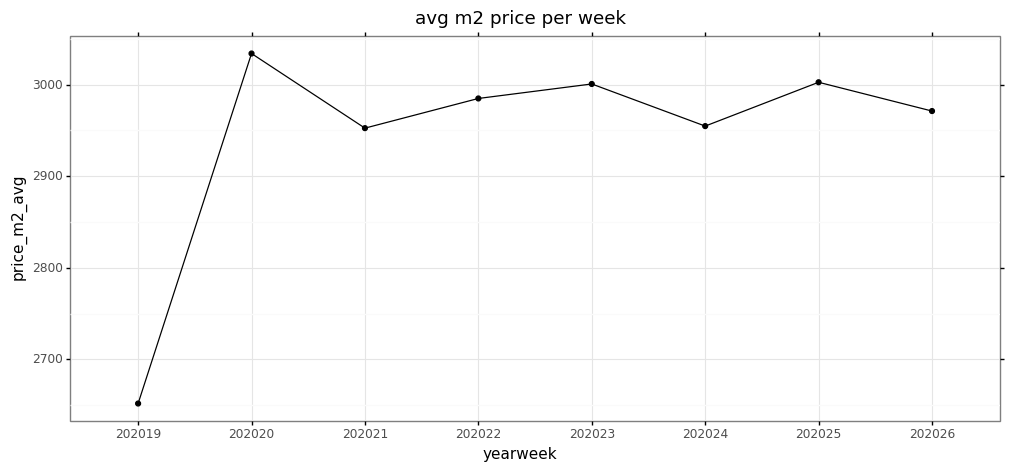

<ggplot: (-9223371882975578196)>


In [73]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', group = 1), 
            data = df12)
    + geom_line()
    + geom_point()
    + labs(title = 'avg m2 price per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

## avg m2 price per category

In [74]:
q13 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df13 = pd.json_normalize(q13)\
    .rename(columns = {'_id.category':'category', '_id.yearweek':'yearweek'})
df13 = df13[['category', 'yearweek', 'price_m2_avg']]
df14 = df13.pivot_table(columns = 'yearweek', index = 'category', values = 'price_m2_avg')

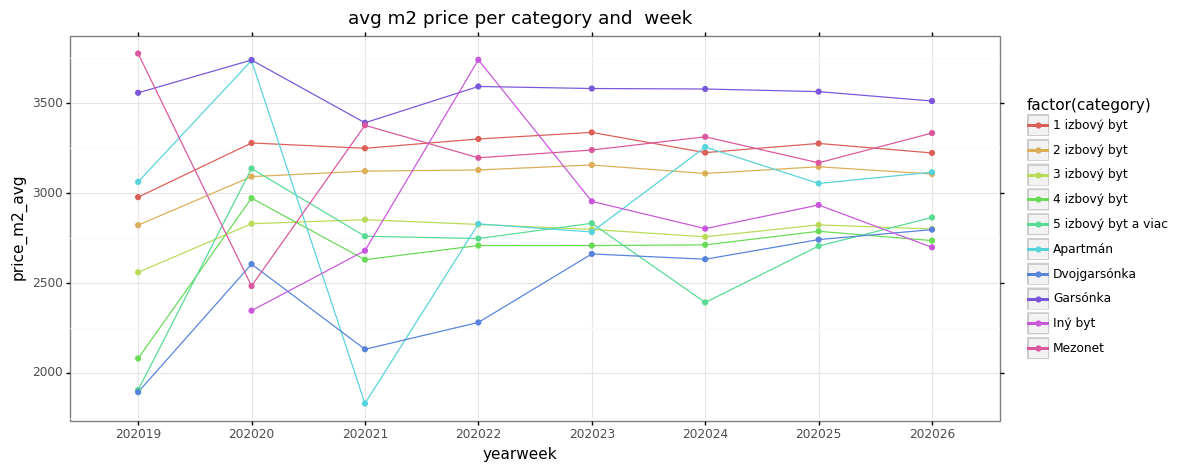

<ggplot: (-9223371882974586500)>


In [75]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(category)', group = 'factor(category)'), 
            data = df13)
    + geom_line()
    + geom_point()
    + labs(title = 'avg m2 price per category and  week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [76]:
df14.style.format("{:.0f}")

In [77]:
q13 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df13 = pd.json_normalize(q13)\
    .rename(columns = {'_id.category':'category'})\
    .sort_values('price_m2_avg', ascending = False)
df13 = df13[['category', 'price_m2_avg']]
df13.style.format({'price_m2_avg':"{:.0f}"})

## avg m2 price per location

In [78]:
q14 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df14 = pd.json_normalize(q14)\
    .rename(columns = {'_id.location':'location', '_id.yearweek':'yearweek'})
df14 = df14.loc[df14['location'].isin(locs), ['location', 'yearweek','price_m2_avg']]
df15 = df14.pivot_table(columns = 'yearweek', index = 'location', values = 'price_m2_avg')

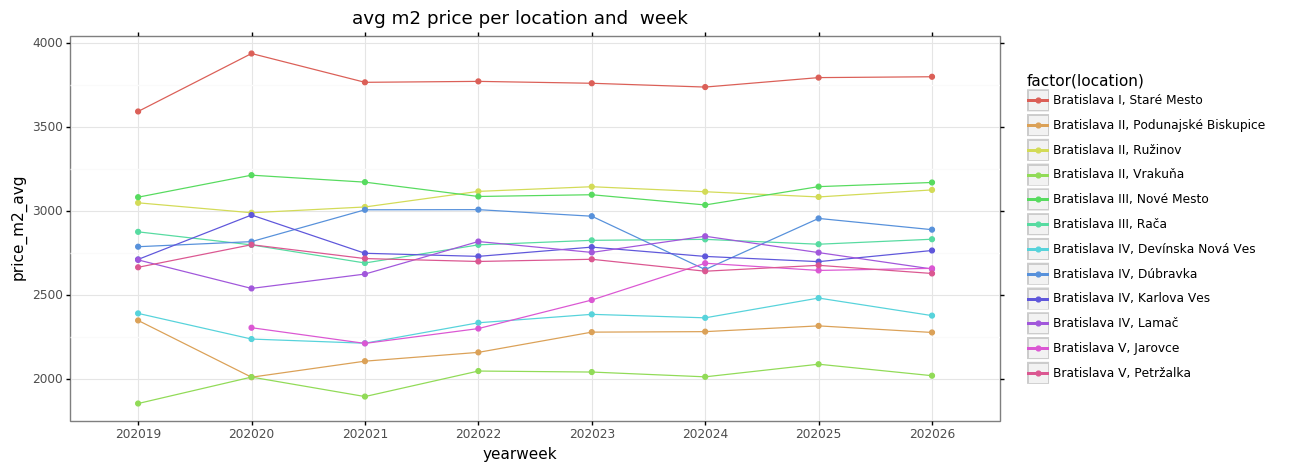

<ggplot: (-9223371882976935592)>


In [79]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df14)
    + geom_line()
    + geom_point()
    + labs(title = 'avg m2 price per location and  week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [80]:
df15.style.format("{:.0f}")

In [81]:
q14 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df14 = pd.json_normalize(q14)\
    .rename(columns = {'_id.location':'location'})\
    .sort_values('price_m2_avg', ascending = False)
df14 = df14[['location', 'price_m2_avg', 'ads_count']]
df14.loc[df14['location'].isin(locs),:].style.format({'price_m2_avg':"{:.0f}"})

## avg m2 price per location and category

In [82]:
q16 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}	
  
  }
	
]))
	
df16 = pd.json_normalize(q16)\
    .rename(columns = {'_id.location':'location', '_id.category':'category', '_id.yearweek':'yearweek'})
df16 = df16.loc[df16['location'].isin(locs), ['location', 'category', 'yearweek', 'price_m2_avg']]
df17 = df16.pivot_table(columns = 'yearweek', index = ['category', 'location'], values = 'price_m2_avg')

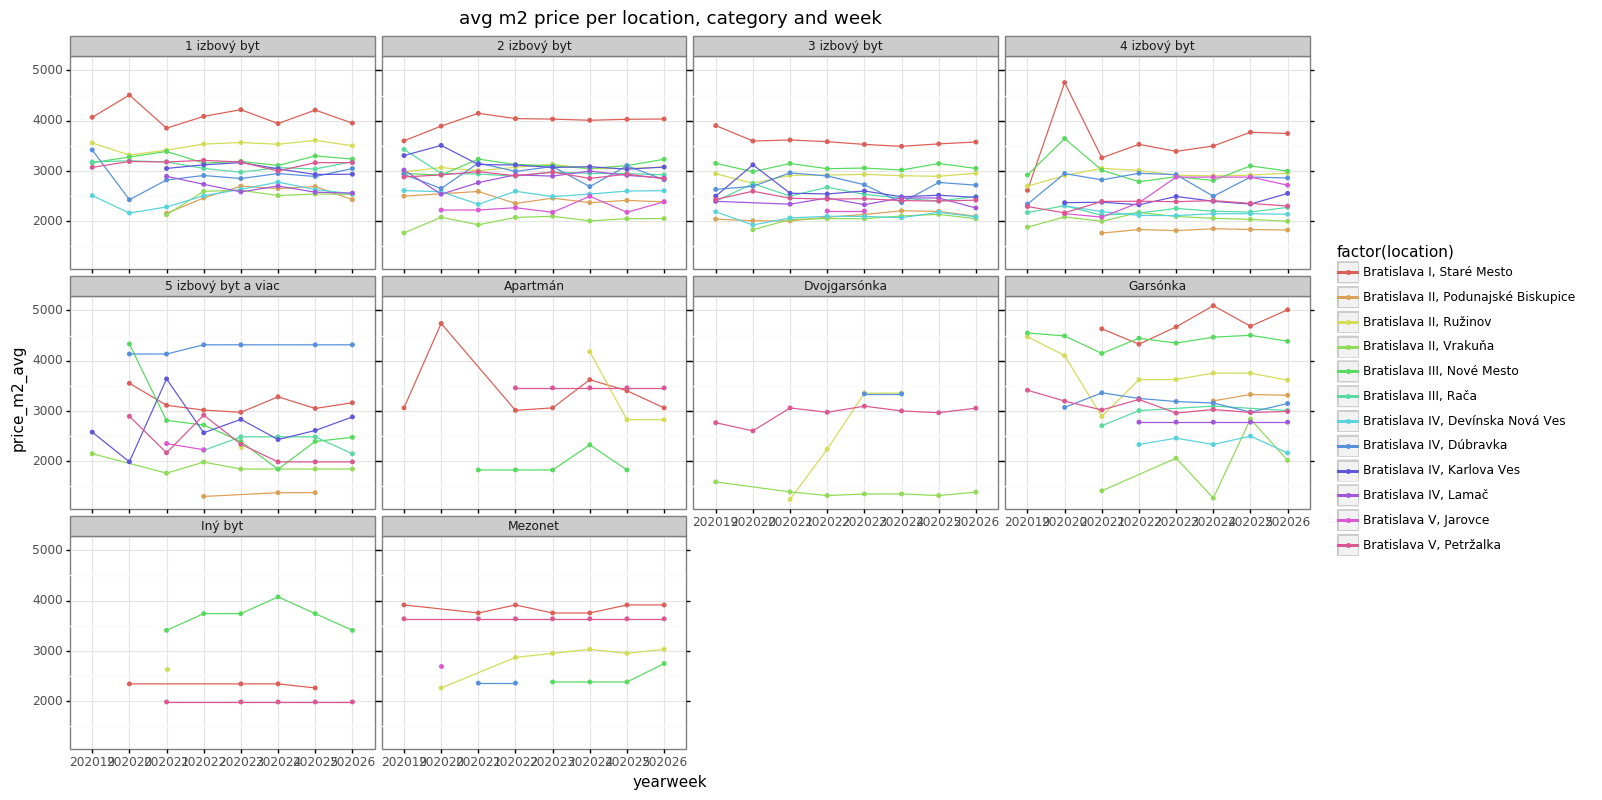

<ggplot: (-9223371882974300736)>


In [83]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg m2 price per location, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [84]:
df17.style.format("{:.0f}", na_rep = '-')

In [85]:
q17 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df17 = pd.json_normalize(q17)\
    .rename(columns = {'_id.location':'location', '_id.category':'category'})\
    .sort_values('price_m2_avg', ascending = False)
df17 = df17[['location', 'category', 'price_m2_avg', 'ads_count']]
df18 = df17.loc[df17['location'].isin(locs),:].pivot(index='location', columns='category', values='price_m2_avg')
df18.style.format("{:.0f}", na_rep = '-')

### 2 room apartment

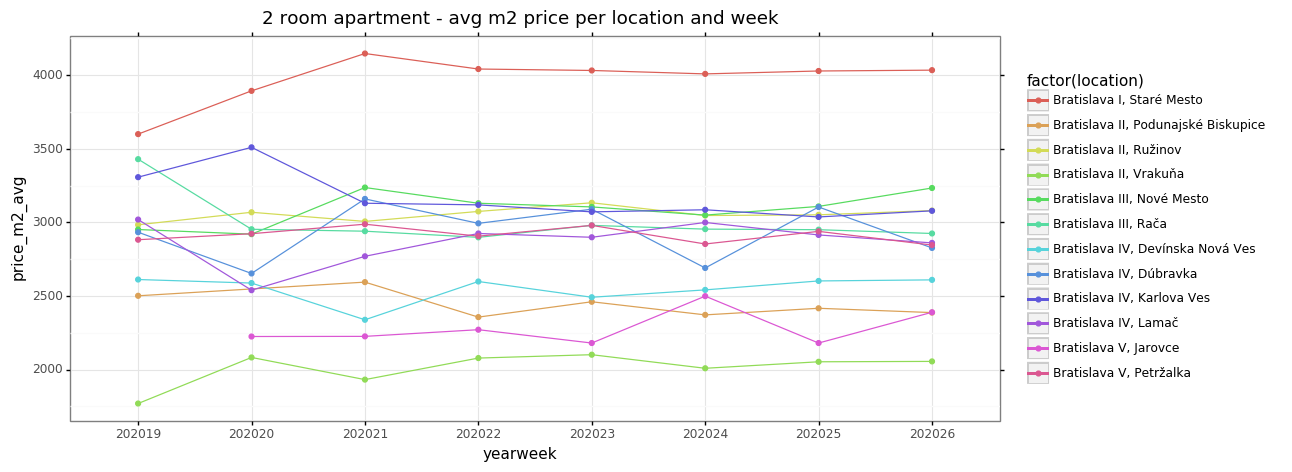

<ggplot: (-9223371882977339176)>


In [86]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16.loc[df16['category'] == '2 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '2 room apartment - avg m2 price per location and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

### 3 room apartment

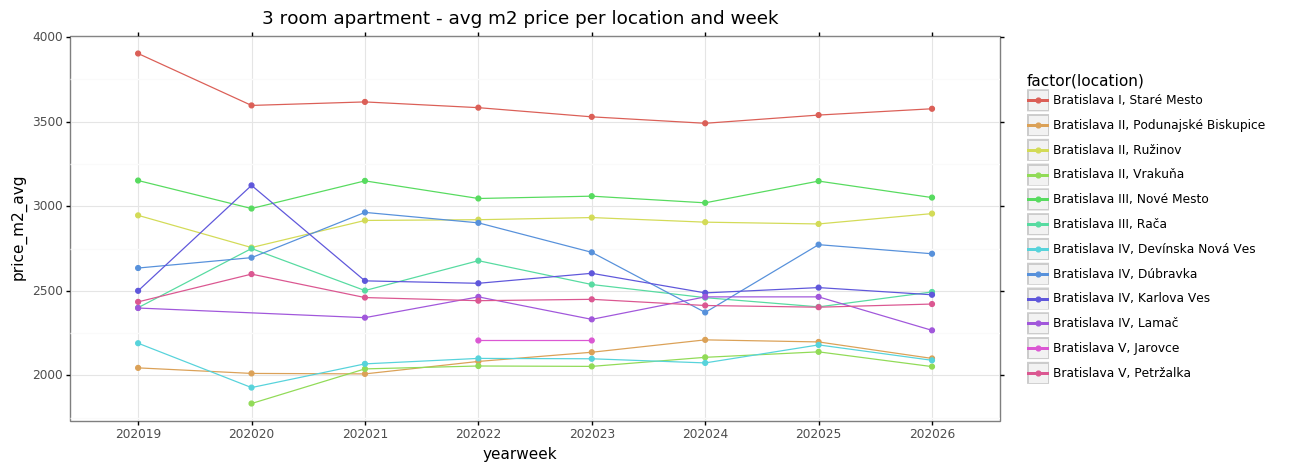

<ggplot: (-9223371882977004860)>


In [87]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16.loc[df16['category'] == '3 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '3 room apartment - avg m2 price per location and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

## avg m2 price per state

In [88]:
q18 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'state':'$properties.Stav'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df18 = pd.json_normalize(q18)\
    .rename(columns = {'_id.state':'state', '_id.yearweek':'yearweek'})
df18 = df18[['state', 'yearweek', 'price_m2_avg']]
df19 = df18.pivot_table(columns = 'yearweek', index = 'state', values = 'price_m2_avg')

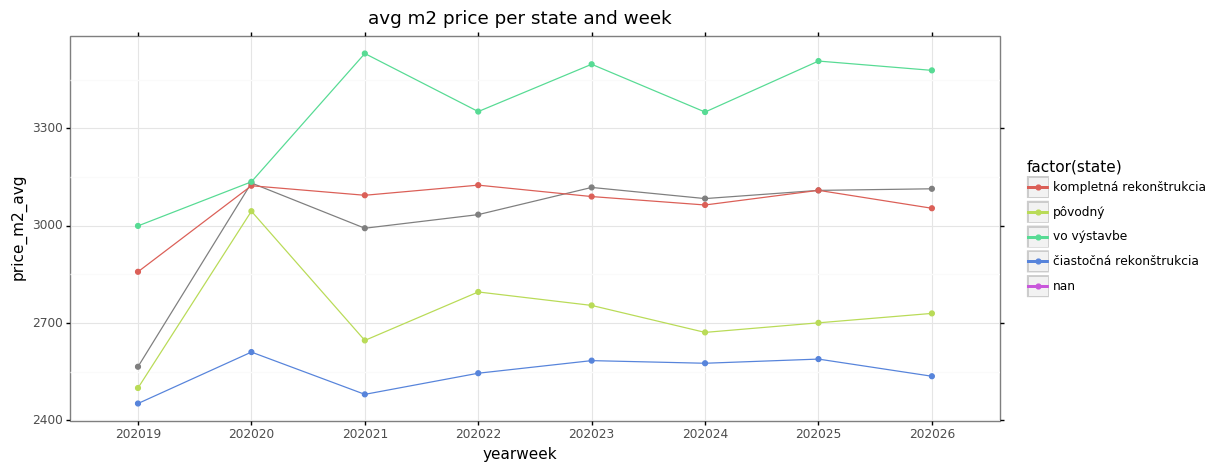

<ggplot: (-9223371882974936388)>


In [89]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df18)
    + geom_line()
    + geom_point()
    + labs(title = 'avg m2 price per state and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [90]:
df19.style.format("{:.0f}")

In [91]:
q18 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'state':'$properties.Stav'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df18 = pd.json_normalize(q18)\
    .rename(columns = {'_id.state':'state'})\
    .sort_values('price_m2_avg', ascending = False)
df18 = df18[['state', 'price_m2_avg', 'ads_count']]
df18.style.format({'price_m2_avg':"{:.0f}"})

## avg m2 price per state and category

In [92]:
q19 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df19 = pd.json_normalize(q19)\
    .rename(columns = {'_id.state':'state', '_id.category':'category', '_id.yearweek': 'yearweek'})
df19 = df19[['state', 'category', 'yearweek', 'price_m2_avg']]
df20 = df19.pivot_table(index = ['category', 'state'], columns = 'yearweek', values = 'price_m2_avg')

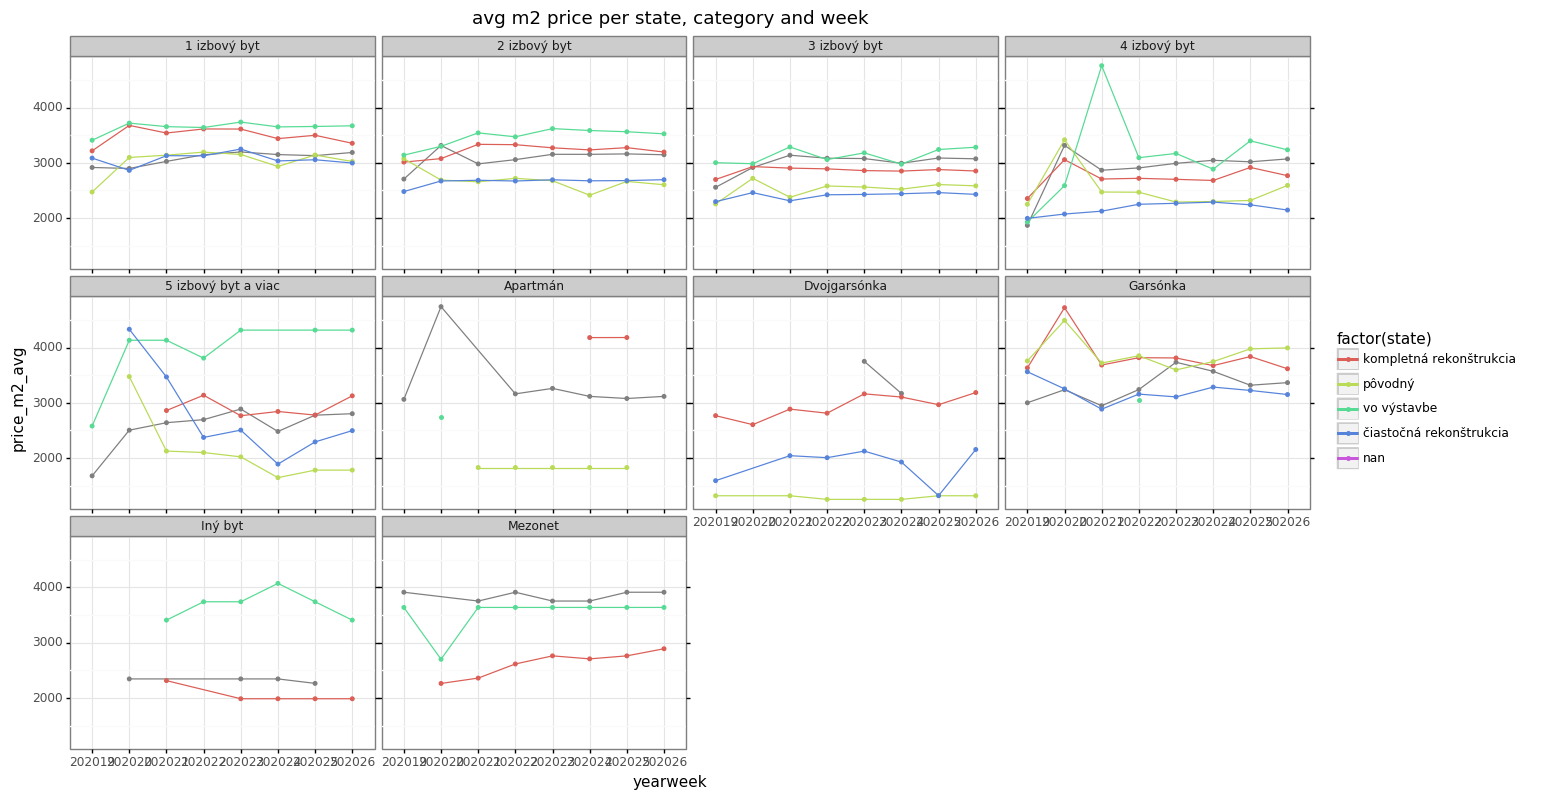

<ggplot: (-9223371882974363756)>


In [93]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df19)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg m2 price per state, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [94]:
df20.style.format("{:.0f}", na_rep = '-')

In [95]:
q19 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df19 = pd.json_normalize(q19)\
    .rename(columns = {'_id.state':'state', '_id.category':'category'})\
    .sort_values(['state', 'price_m2_avg'], ascending = False)
df19 = df19[['state', 'category', 'price_m2_avg', 'ads_count']]
df19 = df19.pivot(index = 'state', columns = 'category', values = 'price_m2_avg')
df19.style.format("{:.0f}", na_rep = '-')

## avg m2 price per state and location

In [96]:
q20 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita', 'state':'$properties.Stav'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df20 = pd.json_normalize(q20)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.yearweek':'yearweek'})
df20 = df20[['location', 'state', 'yearweek', 'price_m2_avg']]
df21 = df20.loc[df20['location'].isin(locs),:].pivot_table(index = ['state', 'location'], columns = 'yearweek', values = 'price_m2_avg')

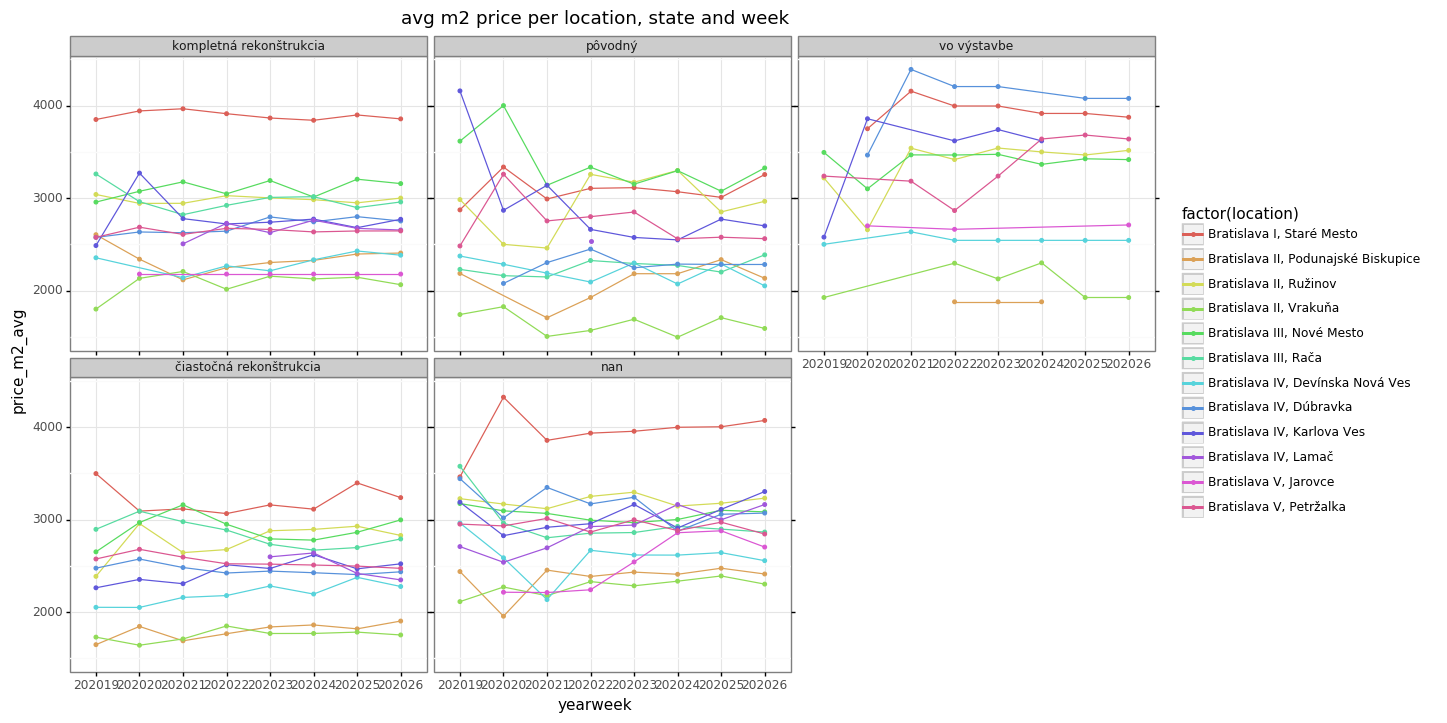

<ggplot: (-9223371882976943540)>


In [97]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df20.loc[df20['location'].isin(locs),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg m2 price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

In [98]:
df21.style.format("{:.0f}", na_rep = '-')

In [99]:
q20 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'state':'$properties.Stav'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df20 = pd.json_normalize(q20)\
    .rename(columns = {'_id.location':'location', '_id.state':'state'})\
    .sort_values('price_m2_avg', ascending = False)
df20 = df20[['location', 'state', 'price_m2_avg', 'ads_count']]
df20 = df20.loc[df20['location'].isin(locs),:].pivot(index = 'location', columns = 'state', values = 'price_m2_avg')
df20.style.format("{:.0f}", na_rep = '-')

## avg m2 price per state, location and category

In [100]:
q21 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek': '$yearweek', 'location':'$properties.Lokalita', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}  
  }
	
]))
	
df21 = pd.json_normalize(q21)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.category':'category', '_id.yearweek':'yearweek'})
df22 = df21.loc[df21['location'].isin(locs),:].pivot_table(index = ['category', 'state', 'location'], columns = 'yearweek', values = 'price_m2_avg')
df22.style.format("{:.0f}", na_rep = '-')

In [101]:
q22 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df22 = pd.json_normalize(q22)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.category':'category'})\
    .sort_values('price_m2_avg', ascending = False)
df22 = df22.loc[df22['location'].isin(locs),:].pivot_table(index = ['location', 'category'], columns = 'state', values = ['price_m2_avg', 'ads_count'])
df22.columns = df22.columns.swaplevel(0, 1)
df22.sort_index(axis=1, level=0, inplace=True)
df22.style.format("{:.0f}", na_rep = '-')

### 2 room apartment

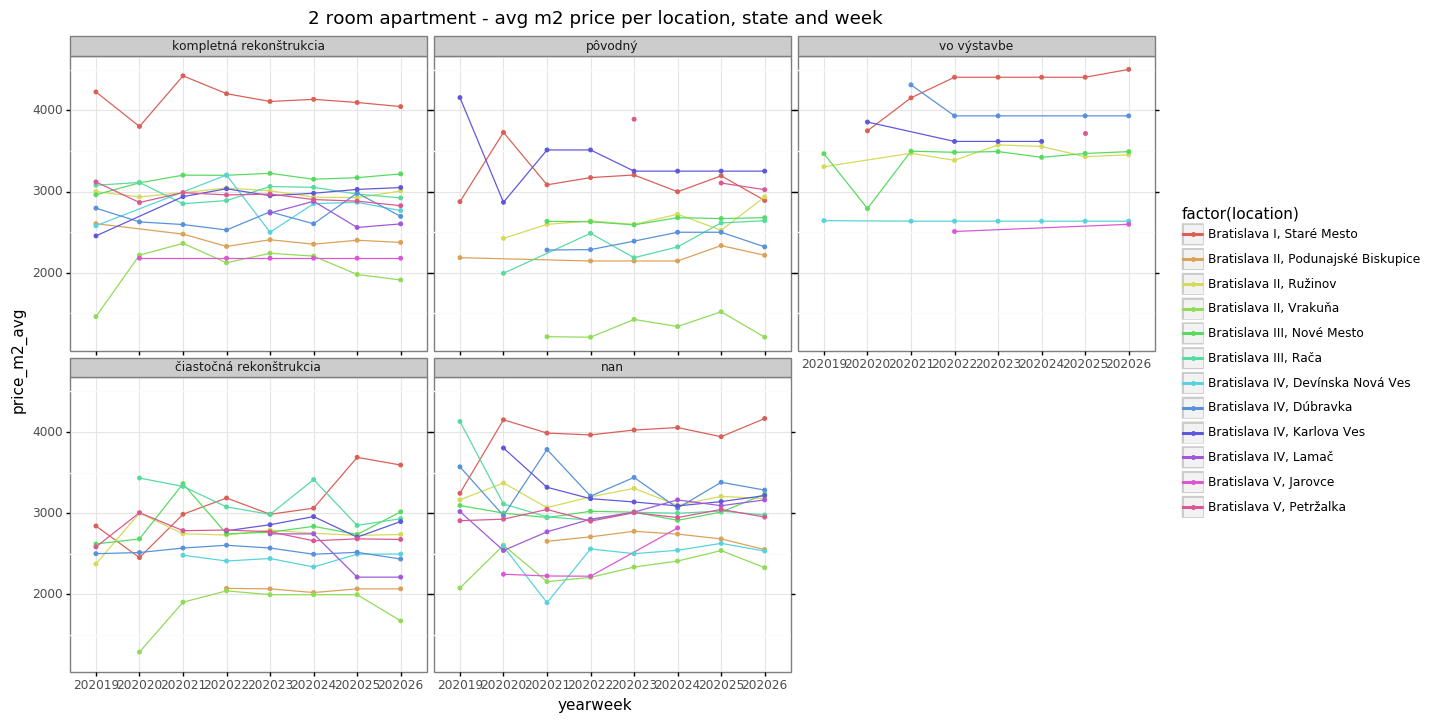

<ggplot: (-9223371882974612712)>


In [102]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df21.loc[(df21['category']== '2 izbový byt') & (df21['location'].isin(locs)),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '2 room apartment - avg m2 price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

### 3 room apartment

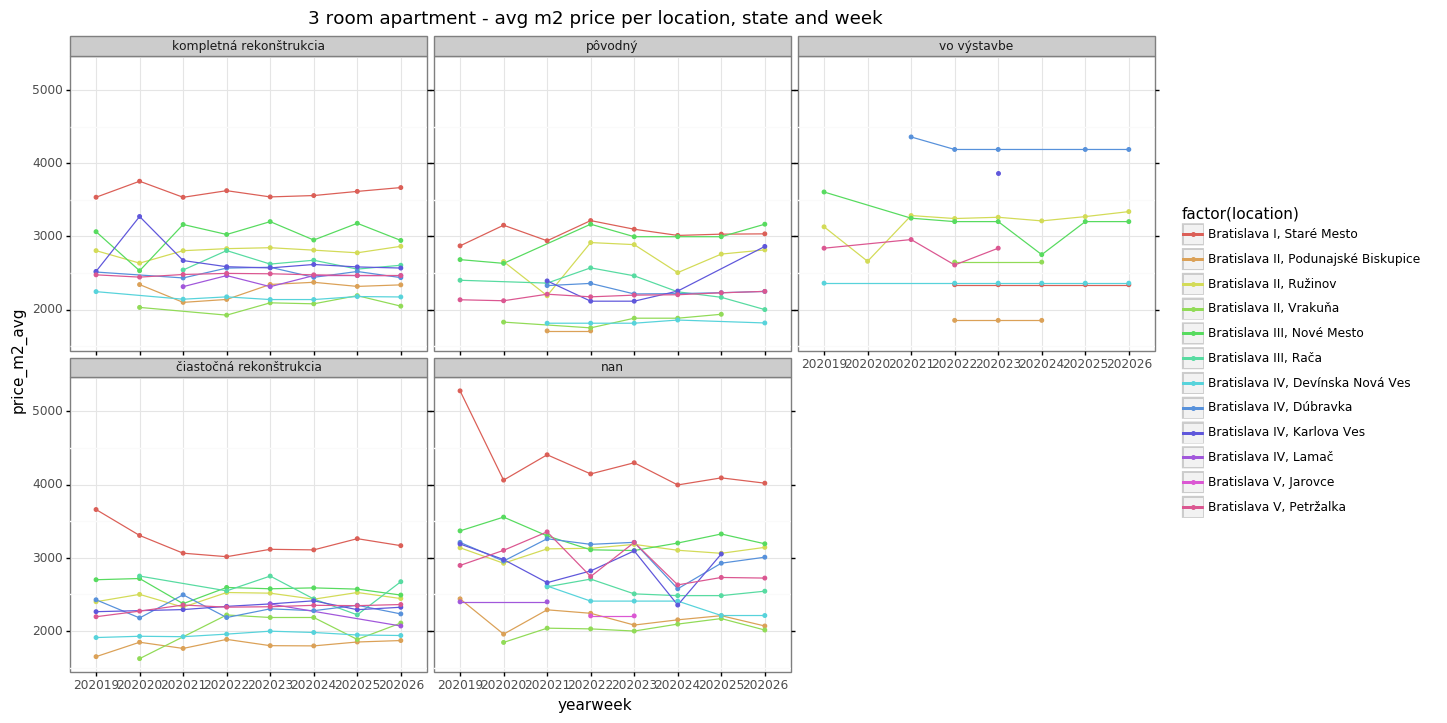

<ggplot: (-9223371882975554300)>


In [103]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df21.loc[(df21['category']== '3 izbový byt') & (df21['location'].isin(locs)),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '3 room apartment - avg m2 price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

# DISTRIBUTION SELECTED CHARTS

In [128]:
q_all = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties.Cena':1, 'properties.Lokalita':1, 'properties.Stav':1, 'properties.Kategória':1, 'properties.Cena za meter':1}
    }
	
]))
	
df_all = pd.json_normalize(q_all)\
    .rename(columns = {'properties.Cena':'price', 'properties.Lokalita':'location', 'properties.Stav':'state', 'properties.Kategória':'category',
                      'properties.Cena za meter':'price_m2'})
df_all.head()

_id yearweek     price                   location  \
0  5ee6422593e00353d3af7c54   202024  184500.0     Bratislava II, Ružinov   
1  5ee658a393e00353d3af83ec   202024  100000.0     Bratislava II, Ružinov   
2  5ee64b1193e00353d3af7f26   202024   69527.0     Bratislava II, Ružinov   
3  5eef759cbaf17818a7fad625   202025  190000.0  Bratislava I, Staré Mesto   
4  5ef897c1a1060c5c024d8000   202026  540000.0  Bratislava I, Staré Mesto   

                     state      category  price_m2  
0  kompletná rekonštrukcia  3 izbový byt    2795.0  
1                      NaN      Garsónka    3125.0  
2                      NaN  2 izbový byt    1738.0  
3  kompletná rekonštrukcia  2 izbový byt    3519.0  
4  kompletná rekonštrukcia  3 izbový byt    3506.0

## overal histogram

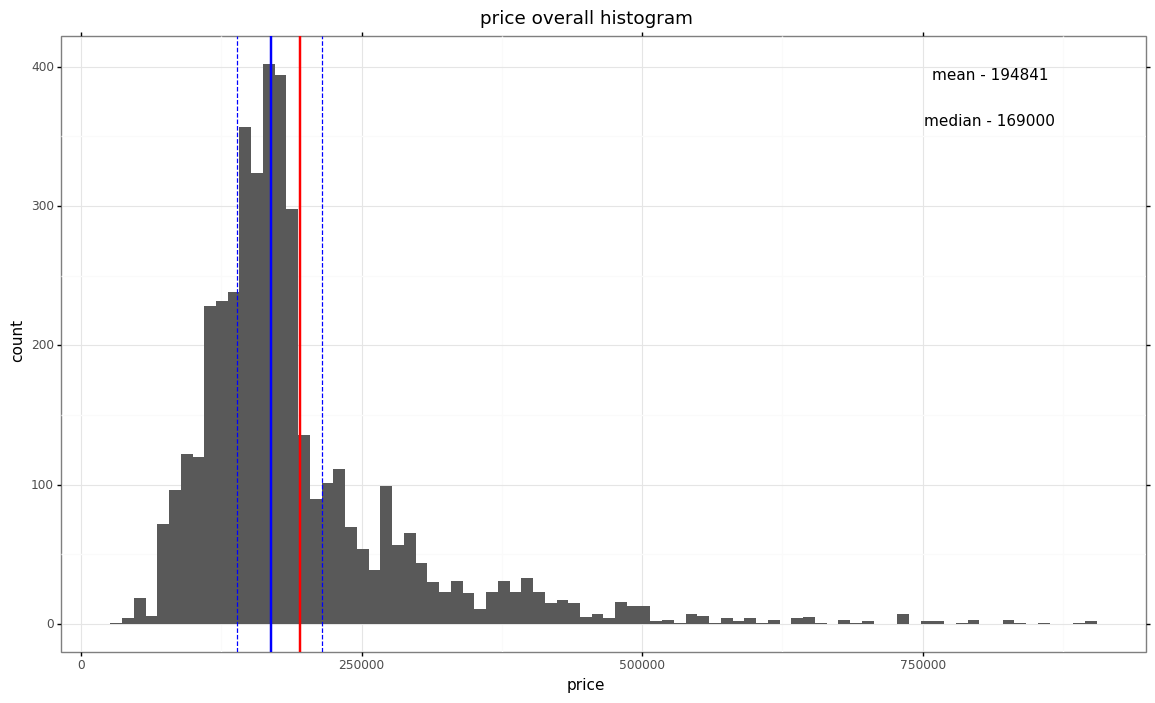

<ggplot: (-9223371882977085484)>


In [139]:
p = (ggplot(aes(x = 'price'), 
            data = df_all)
    + geom_histogram()
    + geom_vline(aes(xintercept = 'price.mean()'), color = 'red', size = 1)
    + geom_vline(aes(xintercept = 'price.median()'), color = 'blue', size = 1)
    + geom_vline(aes(xintercept = 'price.quantile(0.25)'), color = 'blue', linetype = 'dashed')
    + geom_vline(aes(xintercept = 'price.quantile(0.75)'), color = 'blue', linetype = 'dashed')
    + annotate('text', x=0.9*df_all['price'].max(), y = len(df_all)/11, label=f"mean - {int(df_all.price.mean())}")
    + annotate('text', x=0.9*df_all['price'].max(), y = len(df_all)/12, label=f"median - {int(df_all.price.median())}")
    + labs(title = 'price overall histogram')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

# TODO

- another section DISTRIBUTION with charts, percentiles overall and as timeseries
- check properties.Stav vs properties.Stav nehnuteľnosti